In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_recall_curve, roc_auc_score,
                           f1_score, precision_score, recall_score, roc_curve,balanced_accuracy_score)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Categorical encoding
from category_encoders import TargetEncoder

# Visualization and interpretation
import matplotlib.pyplot as plt
import seaborn as sns
import shap
# Note: LIME would be imported as: import lime

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

#### Define the Path for the saved file

In [3]:
path=r"C:\Users\ashish.kumar1\CSL Classification\classification_data_imbalance.xlsx"

In [4]:
def load_and_explore_data(data_path=None, df=None,target_col='diagnosis'):
        
        """
        Load and perform initial exploration of the dataset.
        
        Parameters:
        -----------
        data_path : str, optional
            Path to the dataset file
        df : pd.DataFrame, optional
            Dataframe to use directly
            
        Returns:
        --------
        pd.DataFrame : The loaded dataset
        """
        if df is not None:
            df = df.copy()
        elif data_path is not None:
            if data_path.endswith('.csv'):
                df = pd.read_csv(data_path)
            elif data_path.endswith(('.xlsx', '.xls')):
                df = pd.read_excel(data_path)
            else:
                raise ValueError("Unsupported file format")
        else:
            raise ValueError("Either data_path or df must be provided")
            
        print("=== Dataset Overview ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\n=== Target Distribution ===")
        if target_col in df.columns:
            print(df[target_col].value_counts())
            print(df[target_col].value_counts(normalize=True))
        
        print("\n=== Missing Values ===")
        missing_data = df.isnull().sum()
        print(missing_data[missing_data > 0])
        
        print("\n=== Data Types ===")
        print(df.dtypes.value_counts())
        
        return df

#### First step of setting the model would be idetifying the columns for my model
##### check all the missing values of the columns and get the datatypes

In [5]:
class_data=load_and_explore_data(data_path=path,df=None,target_col='Results')

=== Dataset Overview ===
Shape: (2000, 18)
Columns: ['Patient_id', 'Age ', 'ALBUMIN_MEASUREMENT_TYPE', 'Calculated Globulin', 'FH_CVID', 'FH_SCID', 'CD_HIV_AIDS', 'CD_HEMATOLOGIC_MALIGNANCIES', 'CD_BRONCHIECTASIS', 'MED_CORTICOSTEROIDS', 'MED_CYTOTOXIC_CHEMOTHERAPY', 'MED_MONOCLONAL_ANTIBODIES', 'PX_STEM_CELL_TRANSPLANT', 'IF_LUNG_ABSCESS', 'INF_BACTERIAL_PNEUMONIA,_IDENTIFIED_ORGANISM', 'INF_CHRONIC_SINUSITIS', 'INF_CHRONIC_BRONCHITIS', 'Results ']

=== Target Distribution ===

=== Missing Values ===
Series([], dtype: int64)

=== Data Types ===
int64      14
float64     2
object      2
Name: count, dtype: int64


##### Preprocess Features names and encode the cateegorical values. 
##### If needed go with an argument of Autoselect and let the code chose the best encoding method

In [6]:
def preprocess_data(df, target_col='Result',entity_col='Patient_id',test_size=0.2, use_catboost_encoding=True,
                   random_state=42, cardinality_threshold=10, low_cardinality_encoding='onehot'):
    """
    Comprehensive data preprocessing pipeline with intelligent encoding based on cardinality.
    
    Parameters:
    -----------
    target_col : str
        Name of the target column
    test_size : float
        Proportion of data for testing
    use_catboost_encoding : bool
        If True, use minimal preprocessing for CatBoost (keeps categorical as-is)
    cardinality_threshold : int
        Threshold for high/low cardinality. Features with unique values <= threshold 
        will use simple encoding, others will use target encoding
    low_cardinality_encoding : str
        Encoding method for low cardinality features ('onehot', 'ordinal', or 'none')
        'none' is useful for binary features that are already 0/1
    """
    
    # Uncomment the next line if you have a function to create clinical features
    # df = create_clinical_features(df)
    
    # Separate features and target
    X = df.drop(columns=[target_col,entity_col])
    y = df[target_col]
    
    # Encode target variable
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    
    # Identify categorical and numerical columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Check for binary numerical features (might be categorical in nature)
    binary_numerical = []
    for col in numerical_features.copy():
        unique_vals = X[col].dropna().unique()
        if len(unique_vals) <= 2 and all(val in [0, 1] for val in unique_vals):
            binary_numerical.append(col)
    
    # Analyze cardinality for categorical features
    low_cardinality_cat = []
    high_cardinality_cat = []
    
    for col in categorical_features:
        cardinality = X[col].nunique()
        if cardinality <= cardinality_threshold:
            low_cardinality_cat.append(col)
        else:
            high_cardinality_cat.append(col)
    
    print(f"Binary numerical columns ({len(binary_numerical)}): {binary_numerical}")
    print(f"Low cardinality categorical ({len(low_cardinality_cat)}): {low_cardinality_cat}")
    print(f"High cardinality categorical ({len(high_cardinality_cat)}): {high_cardinality_cat}")
    print(f"Other numerical columns ({len(numerical_features) - len(binary_numerical)}): "
          f"{[col for col in numerical_features if col not in binary_numerical]}")
    
    # Split data first
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, 
        stratify=y_encoded, random_state=random_state
    )
    
    if use_catboost_encoding:
        # For CatBoost: minimal preprocessing, keep categorical features as strings
        X_train_cat = X_train.copy()
        X_test_cat = X_test.copy()
        
        # Fill missing values
        for col in categorical_features:
            mode_val = X_train_cat[col].mode()[0] if not X_train_cat[col].mode().empty else 'Unknown'
            X_train_cat[col].fillna(mode_val, inplace=True)
            X_test_cat[col].fillna(mode_val, inplace=True)
            X_train_cat[col] = X_train_cat[col].astype(str)
            X_test_cat[col] = X_test_cat[col].astype(str)
        
        for col in numerical_features:
            mean_val = X_train_cat[col].mean()
            X_train_cat[col].fillna(mean_val, inplace=True)
            X_test_cat[col].fillna(mean_val, inplace=True)
        
        X_train_catboost = X_train_cat
        X_test_catboost = X_test_cat
        categorical_feature_indices = [i for i, col in enumerate(X_train_cat.columns) 
                                      if col in categorical_features]
    
    # Create preprocessing pipelines for other models
    transformers = []
    
    # Handle low cardinality categorical features
    if low_cardinality_cat:
        if low_cardinality_encoding == 'onehot':
            low_cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
            ])
        elif low_cardinality_encoding == 'ordinal':
            low_cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
            ])
        else:  # 'none' - just impute
            low_cat_transformer = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent'))
            ])
        
        transformers.append(('low_cat', low_cat_transformer, low_cardinality_cat))
    
    # Handle high cardinality categorical features with target encoding
    if high_cardinality_cat:
        from category_encoders import TargetEncoder
        high_cat_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('target_encoder', TargetEncoder())
        ])
        transformers.append(('high_cat', high_cat_transformer, high_cardinality_cat))
    
    # Handle binary numerical features (minimal processing)
    if binary_numerical:
        binary_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent'))  # Use mode for binary
        ])
        transformers.append(('binary', binary_transformer, binary_numerical))
    
    # Handle other numerical features
    other_numerical = [col for col in numerical_features if col not in binary_numerical]
    if other_numerical:
        numerical_transformer = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numerical_transformer, other_numerical))
    
    # Combine all transformers
    if transformers:
        preprocessor = ColumnTransformer(transformers)
        
        # Fit preprocessor and transform data
        X_train_processed = preprocessor.fit_transform(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
        
        # Get feature names after preprocessing
        feature_names = []
        for name, transformer, columns in transformers:
            if name == 'low_cat' and low_cardinality_encoding == 'onehot':
                # OneHot creates multiple columns
                try:
                    encoded_features = transformer.named_steps['onehot'].get_feature_names_out(columns)
                    feature_names.extend(encoded_features)
                except:
                    feature_names.extend(columns)  # Fallback
            else:
                feature_names.extend(columns)
    else:
        # No transformations needed
        X_train_processed = X_train.values
        X_test_processed = X_test.values
        feature_names = X_train.columns.tolist()
        preprocessor = None
    
    print(f"Training set shape: {X_train_processed.shape}")
    print(f"Test set shape: {X_test_processed.shape}")
    print(f"Class distribution in training: {np.bincount(y_train)}")
    
    result = {
        'X_train': X_train_processed,
        'X_test': X_test_processed,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': feature_names,
        'target_encoder': target_encoder,
        'preprocessor': preprocessor
    }
    
    if use_catboost_encoding:
        result.update({
            'X_train_catboost': X_train_catboost,
            'X_test_catboost': X_test_catboost,
            'categorical_feature_indices': categorical_feature_indices
        })
    
    return result


# Example usage:
"""
# For mostly binary features, you might want:
data = preprocess_data(df, 
                      cardinality_threshold=5,  # Only features with >5 unique values get target encoding
                      low_cardinality_encoding='none')  # Don't transform binary features

# For mixed data with some high cardinality features:
data = preprocess_data(df, 
                      cardinality_threshold=10,
                      low_cardinality_encoding='onehot')

# Access results:
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
feature_names = data['feature_names']

# For CatBoost:
X_train_cb = data['X_train_catboost']
cat_features = data['categorical_feature_indices']
"""

"\n# For mostly binary features, you might want:\ndata = preprocess_data(df, \n                      cardinality_threshold=5,  # Only features with >5 unique values get target encoding\n                      low_cardinality_encoding='none')  # Don't transform binary features\n\n# For mixed data with some high cardinality features:\ndata = preprocess_data(df, \n                      cardinality_threshold=10,\n                      low_cardinality_encoding='onehot')\n\n# Access results:\nX_train, X_test = data['X_train'], data['X_test']\ny_train, y_test = data['y_train'], data['y_test']\nfeature_names = data['feature_names']\n\n# For CatBoost:\nX_train_cb = data['X_train_catboost']\ncat_features = data['categorical_feature_indices']\n"

In [7]:
data = preprocess_data(class_data,    
                      cardinality_threshold=10,
                      low_cardinality_encoding='onehot',target_col='Results ')

Binary numerical columns (13): ['FH_CVID', 'FH_SCID', 'CD_HIV_AIDS', 'CD_HEMATOLOGIC_MALIGNANCIES', 'CD_BRONCHIECTASIS', 'MED_CORTICOSTEROIDS', 'MED_CYTOTOXIC_CHEMOTHERAPY', 'MED_MONOCLONAL_ANTIBODIES', 'PX_STEM_CELL_TRANSPLANT', 'IF_LUNG_ABSCESS', 'INF_BACTERIAL_PNEUMONIA,_IDENTIFIED_ORGANISM', 'INF_CHRONIC_SINUSITIS', 'INF_CHRONIC_BRONCHITIS']
Low cardinality categorical (1): ['ALBUMIN_MEASUREMENT_TYPE']
High cardinality categorical (0): []
Other numerical columns (2): ['Age ', 'Calculated Globulin']
Training set shape: (1600, 16)
Test set shape: (400, 16)
Class distribution in training: [1200  240  160]


### Split the data and save it in Dataframe to use while coding 

In [8]:
# Access results:
X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
feature_names = data['feature_names']
X_train_catboost= data['X_train_catboost']
X_test_catboost=data['X_test_catboost']
cat_features = data['categorical_feature_indices']

In [9]:
## check the size and rows 
X_train.shape

(1600, 16)

### Initializing the model- Use Catboost as option

In [10]:
def initialize_models(random_state=42, categorical_feature_indices=None):
    """Initialize various models for comparison, optimized for categorical features."""
    models = {
        # 'CatBoost': CatBoostClassifier(
        #     random_state=random_state,
        #     verbose=False,
        #     iterations=500,
        #     learning_rate=0.1,
        #     depth=6,
        #     cat_features=categorical_feature_indices if categorical_feature_indices else [],
        #     train_dir=None
        # ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=random_state
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=random_state,
            eval_metric='mlogloss',
            scale_pos_weight=2
        ),
        'LightGBM': lgb.LGBMClassifier(
            random_state=random_state,
            verbose=-1,
            class_weight='balanced'
        ),
        'LogisticRegression': LogisticRegression(
            class_weight='balanced',
            random_state=random_state,
            max_iter=1000
        ),
        'GradientBoosting': GradientBoostingClassifier(
            random_state=random_state
        )
    }
    return models

In [13]:
base_models= initialize_models(random_state=42, categorical_feature_indices=cat_features)

#### Feature Impotance fucntion based on the shap values and sample size of 1000

In [12]:
def get_feature_importance(model, model_name, X_train, feature_names, use_shap=False, max_samples=100):
    """
    Extract feature importance from models using built-in methods or SHAP values.
    
    Parameters:
    -----------
    model : trained model
        The fitted model
    model_name : str
        Name of the model
    X_train : DataFrame or array
        Training data for SHAP calculations
    feature_names : list
        List of feature names
    use_shap : bool
        Whether to use SHAP values for feature importance
    max_samples : int
        Maximum samples to use for SHAP calculation (for performance)
    
    Returns:
    --------
    dict : Dictionary containing feature importance information
    """
    importance_info = {}
    
    if use_shap and SHAP_AVAILABLE:
        try:
            # Sample data for SHAP if dataset is large
            if len(X_train) > max_samples:
                sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
                X_sample = X_train.iloc[sample_idx] if hasattr(X_train, 'iloc') else X_train[sample_idx]
            else:
                X_sample = X_train
            
            # Choose appropriate SHAP explainer based on model type
            if model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']:
                explainer = shap.TreeExplainer(model)
            elif model_name == 'CatBoost':
                explainer = shap.TreeExplainer(model)
            elif model_name == 'LogisticRegression':
                explainer = shap.LinearExplainer(model, X_sample)
            else:
                explainer = shap.Explainer(model, X_sample)
            
            shap_values = explainer.shap_values(X_sample)
            
            # Handle multiclass case
            if len(shap_values.shape) == 3:  # multiclass
                # Use mean absolute SHAP values across classes
                importance_values = np.mean(np.abs(shap_values), axis=(0, 2))
            else:
                importance_values = np.mean(np.abs(shap_values), axis=0)
            
            importance_info['shap_importance'] = importance_values
            importance_info['shap_values'] = shap_values
            
        except Exception as e:
            print(f"SHAP calculation failed for {model_name}: {str(e)}")
            importance_info['shap_importance'] = None
    
    # Built-in feature importance
    if hasattr(model, 'feature_importances_'):
        importance_info['builtin_importance'] = model.feature_importances_
    elif model_name == 'CatBoost':
        importance_info['builtin_importance'] = model.get_feature_importance()
    elif model_name == 'LogisticRegression':
        # Use absolute values of coefficients as importance
        if len(model.coef_.shape) > 1:  # multiclass
            importance_info['builtin_importance'] = np.mean(np.abs(model.coef_), axis=0)
        else:
            importance_info['builtin_importance'] = np.abs(model.coef_[0])
    else:
        importance_info['builtin_importance'] = None
    
    # Create feature importance DataFrame
    if importance_info.get('builtin_importance') is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_info['builtin_importance']
        }).sort_values('importance', ascending=False)
        importance_info['importance_df'] = importance_df
    
    if importance_info.get('shap_importance') is not None:
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': importance_info['shap_importance']
        }).sort_values('shap_importance', ascending=False)
        importance_info['shap_df'] = shap_df
    
    return importance_info

#### Train the model and evaluate the performance

In [ ]:
def train_and_evaluate_models(data, models=None, cv_folds=5, random_state=42, 
                            use_shap=False, shap_max_samples=100):
    """
    Train and evaluate all models using cross-validation.
    Handles CatBoost separately due to its categorical feature requirements.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing train/test splits and feature information
    models : dict
        Dictionary of models to train
    cv_folds : int
        Number of cross-validation folds
    random_state : int
        Random state for reproducibility
    use_shap : bool
        Whether to calculate SHAP feature importance
    shap_max_samples : int
        Maximum samples for SHAP calculation
    """
    if not models:
        models = initialize_models(random_state=random_state, 
                                 categorical_feature_indices=data.get('categorical_feature_indices'))

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    feature_names = data['feature_names']
    X_train_catboost = data['X_train_catboost']
    X_test_catboost = data['X_test_catboost']
    cat_features = data['categorical_feature_indices']
    
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use appropriate data based on model type
        if name == 'CatBoost':
            X_train_model = X_train_catboost
            X_test_model = X_test_catboost
            
            # Cross-validation for CatBoost
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train_model, y_train):
                X_cv_train, X_cv_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
                y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                
                model_cv = CatBoostClassifier(
                    random_state=random_state,
                    verbose=False,
                    iterations=500,
                    cat_features=cat_features,
                    train_dir=None
                )
                model_cv.fit(X_cv_train, y_cv_train)
                y_pred_cv = model_cv.predict(X_cv_val)
                cv_scores.append(f1_score(y_cv_val, y_pred_cv, average='macro'))
            
            cv_scores = np.array(cv_scores)
            
            # Fit final model
            model.fit(X_train_model, y_train)
            y_pred = model.predict(X_test_model)
            y_pred_proba = model.predict_proba(X_test_model)
            
        else:
            X_train_model = X_train
            X_test_model = X_test
            
            # Cross-validation scores
            cv_scores = cross_val_score(model, X_train_model, y_train, 
                                      cv=cv, scoring='f1_macro')
            
            # Fit model
            model.fit(X_train_model, y_train)
            y_pred = model.predict(X_test_model)
            y_pred_proba = model.predict_proba(X_test_model)
        
        # Calculate metrics
        results[name] = {
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_precision': precision_score(y_test, y_pred, average='macro'),
            'test_recall': recall_score(y_test, y_pred, average='macro'),
            'test_f1': f1_score(y_test, y_pred, average='macro'),
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'model': model  # Store the trained model
        }
        
        # ROC AUC for multiclass
        try:
            results[name]['test_auc'] = roc_auc_score(y_test, y_pred_proba, 
                                                    multi_class='ovr', average='macro')
        except:
            results[name]['test_auc'] = np.nan
        
        # Feature importance analysis
        print(f"Calculating feature importance for {name}...")
        importance_info = get_feature_importance(
            model, name, X_train_model, feature_names, 
            use_shap=use_shap, max_samples=shap_max_samples
        )
        results[name]['feature_importance'] = importance_info
    
    return results

In [ ]:
def plot_feature_importance(results, model_name, top_n=20, importance_type='builtin'):
    """
    Plot feature importance for a specific model.
    
    Parameters:
    -----------
    results : dict
        Results from train_and_evaluate_models
    model_name : str
        Name of the model to plot
    top_n : int
        Number of top features to display
    importance_type : str
        'builtin' or 'shap' - type of importance to plot
    """
    import matplotlib.pyplot as plt
    
    if model_name not in results:
        print(f"Model {model_name} not found in results")
        return
    
    importance_info = results[model_name]['feature_importance']
    
    if importance_type == 'builtin' and 'importance_df' in importance_info:
        df = importance_info['importance_df'].head(top_n)
        title = f'{model_name} - Built-in Feature Importance (Top {top_n})'
        y_label = 'Feature Importance'
    elif importance_type == 'shap' and 'shap_df' in importance_info:
        df = importance_info['shap_df'].head(top_n)
        title = f'{model_name} - SHAP Feature Importance (Top {top_n})'
        y_label = 'Mean |SHAP Value|'
    else:
        print(f"Feature importance type '{importance_type}' not available for {model_name}")
        return
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(df)), df.iloc[:, 1].values)
    plt.yticks(range(len(df)), df.iloc[:, 0].values)
    plt.xlabel(y_label)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize models first
models = initialize_models(random_state=42)

# Single training call - combine the parameters from both of your current calls
results = train_and_evaluate_models(
    data=data, 
    models=models,
    cv_folds=5,
    random_state=42,
    use_shap=True,
    shap_max_samples=10000
)



Training RandomForest...
Calculating feature importance for RandomForest...

Training XGBoost...
Calculating feature importance for XGBoost...

Training LightGBM...
Calculating feature importance for LightGBM...

Training LogisticRegression...
Calculating feature importance for LogisticRegression...

Training GradientBoosting...
Calculating feature importance for GradientBoosting...
SHAP calculation failed for GradientBoosting: GradientBoostingClassifier is only supported for binary classification right now!


### Same function but with Calibrated probalibilty

In [63]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import seaborn as sns

def train_and_evaluate_models_with_calibration(data, models=None, cv_folds=5, random_state=42, 
                                             use_shap=False, shap_max_samples=100,
                                             calibration_method='platt', calibration_cv=3):
    """
    Train and evaluate all models using cross-validation with probability calibration.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing train/test splits and feature information
    models : dict
        Dictionary of models to train
    cv_folds : int
        Number of cross-validation folds
    random_state : int
        Random state for reproducibility
    use_shap : bool
        Whether to calculate SHAP feature importance
    shap_max_samples : int
        Maximum samples for SHAP calculation
    calibration_method : str
        'platt' for Platt scaling, 'isotonic' for isotonic regression
    calibration_cv : int
        Number of CV folds for calibration
    """
    if not models:
        models = initialize_models(random_state=random_state, 
                                 categorical_feature_indices=data.get('categorical_feature_indices'))

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    feature_names = data['feature_names']
    X_train_catboost = data['X_train_catboost']
    X_test_catboost = data['X_test_catboost']
    cat_features = data['categorical_feature_indices']
    
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use appropriate data based on model type
        if name == 'CatBoost':
            X_train_model = X_train_catboost
            X_test_model = X_test_catboost
            
            # Cross-validation for CatBoost
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train_model, y_train):
                X_cv_train, X_cv_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
                y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                
                model_cv = CatBoostClassifier(
                    random_state=random_state,
                    verbose=False,
                    iterations=500,
                    cat_features=cat_features,
                    train_dir=None
                )
                model_cv.fit(X_cv_train, y_cv_train)
                y_pred_cv = model_cv.predict(X_cv_val)
                cv_scores.append(f1_score(y_cv_val, y_pred_cv, average='macro'))
            
            cv_scores = np.array(cv_scores)
            
            # Fit final model
            model.fit(X_train_model, y_train)
            
            # Create calibrated model for CatBoost
            calibrated_model = CalibratedClassifierCV(
                model, method=calibration_method, cv=calibration_cv
            )
            calibrated_model.fit(X_train_model, y_train)
            
            # Get predictions
            y_pred = model.predict(X_test_model)
            y_pred_proba_raw = model.predict_proba(X_test_model)
            y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_model)
            
        else:
            X_train_model = X_train
            X_test_model = X_test
            
            # Cross-validation scores
            cv_scores = cross_val_score(model, X_train_model, y_train, 
                                      cv=cv, scoring='f1_macro')
            
            # Fit model
            model.fit(X_train_model, y_train)
            
            # Create calibrated model
            calibrated_model = CalibratedClassifierCV(
                model, method=calibration_method, cv=calibration_cv
            )
            calibrated_model.fit(X_train_model, y_train)
            
            # Get predictions
            y_pred = model.predict(X_test_model)
            y_pred_proba_raw = model.predict_proba(X_test_model)
            y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_model)
        
        # Calculate calibration metrics
        calibration_metrics = calculate_calibration_metrics(
            y_test, y_pred_proba_raw, y_pred_proba_calibrated
        )
        
        # Calculate risk scores
        risk_scores = calculate_risk_scores(y_pred_proba_calibrated, y_test)
        
        # Calculate standard metrics
        results[name] = {
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_precision': precision_score(y_test, y_pred, average='macro'),
            'test_recall': recall_score(y_test, y_pred, average='macro'),
            'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'test_f1': f1_score(y_test, y_pred, average='macro'),
            'predictions': y_pred,
            'probabilities_raw': y_pred_proba_raw,
            'probabilities_calibrated': y_pred_proba_calibrated,
            'risk_scores': risk_scores,
            'calibration_metrics': calibration_metrics,
            'model': model,
            'calibrated_model': calibrated_model
        }
        
        # ROC AUC for multiclass
        try:
            results[name]['test_auc_raw'] = roc_auc_score(y_test, y_pred_proba_raw, 
                                                        multi_class='ovr', average='macro')
            results[name]['test_auc_calibrated'] = roc_auc_score(y_test, y_pred_proba_calibrated, 
                                                               multi_class='ovr', average='macro')
        except:
            results[name]['test_auc_raw'] = np.nan
            results[name]['test_auc_calibrated'] = np.nan
        
        # Feature importance analysis
        print(f"Calculating feature importance for {name}...")
        importance_info = get_feature_importance(
            model, name, X_train_model, feature_names, 
            use_shap=use_shap, max_samples=shap_max_samples
        )
        results[name]['feature_importance'] = importance_info
    
    return results


def calculate_calibration_metrics(y_true, y_prob_raw, y_prob_calibrated):
    """
    Calculate calibration metrics comparing raw vs calibrated probabilities.
    """
    from sklearn.calibration import calibration_curve
    from sklearn.metrics import brier_score_loss
    
    calibration_metrics = {}
    
    # For multiclass, we'll focus on the positive class or highest probability class
    if y_prob_raw.shape[1] > 2:
        # For multiclass, use the max probability approach
        y_prob_raw_max = np.max(y_prob_raw, axis=1)
        y_prob_cal_max = np.max(y_prob_calibrated, axis=1)
        y_true_binary = (np.argmax(y_prob_raw, axis=1) == y_true).astype(int)
    else:
        # For binary classification
        y_prob_raw_max = y_prob_raw[:, 1]
        y_prob_cal_max = y_prob_calibrated[:, 1]
        y_true_binary = y_true
    
    # Brier Score (lower is better)
    try:
        brier_raw = brier_score_loss(y_true_binary, y_prob_raw_max)
        brier_calibrated = brier_score_loss(y_true_binary, y_prob_cal_max)
        calibration_metrics['brier_score_raw'] = brier_raw
        calibration_metrics['brier_score_calibrated'] = brier_calibrated
        calibration_metrics['brier_improvement'] = brier_raw - brier_calibrated
    except:
        calibration_metrics['brier_score_raw'] = np.nan
        calibration_metrics['brier_score_calibrated'] = np.nan
        calibration_metrics['brier_improvement'] = np.nan
    
    # Calibration curve data
    try:
        fraction_pos_raw, mean_pred_raw = calibration_curve(
            y_true_binary, y_prob_raw_max, n_bins=10
        )
        fraction_pos_cal, mean_pred_cal = calibration_curve(
            y_true_binary, y_prob_cal_max, n_bins=10
        )
        
        calibration_metrics['calibration_curve_raw'] = {
            'fraction_positives': fraction_pos_raw,
            'mean_predicted': mean_pred_raw
        }
        calibration_metrics['calibration_curve_calibrated'] = {
            'fraction_positives': fraction_pos_cal,
            'mean_predicted': mean_pred_cal
        }
    except:
        calibration_metrics['calibration_curve_raw'] = None
        calibration_metrics['calibration_curve_calibrated'] = None
    
    return calibration_metrics


def calculate_risk_scores(y_prob_calibrated, y_true=None):
    """
    Calculate interpretable risk scores from calibrated probabilities.
    """
    risk_scores = {}
    
    # Maximum class probability as primary risk score
    max_prob = np.max(y_prob_calibrated, axis=1)
    predicted_class = np.argmax(y_prob_calibrated, axis=1)
    
    # Risk categories based on probability thresholds
    risk_categories = np.where(
        max_prob >= 0.8, 'High Risk',
        np.where(max_prob >= 0.6, 'Medium Risk',
                np.where(max_prob >= 0.4, 'Low Risk', 'Very Low Risk'))
    )
    
    risk_scores['max_probability'] = max_prob
    risk_scores['predicted_class'] = predicted_class
    risk_scores['risk_category'] = risk_categories
    risk_scores['class_probabilities'] = y_prob_calibrated
    
    # If we have true labels, calculate risk score performance
    if y_true is not None:
        # Risk score accuracy by category
        risk_performance = {}
        for category in np.unique(risk_categories):
            mask = risk_categories == category
            if np.sum(mask) > 0:
                accuracy = accuracy_score(y_true[mask], predicted_class[mask])
                risk_performance[category] = {
                    'count': np.sum(mask),
                    'accuracy': accuracy,
                    'mean_probability': np.mean(max_prob[mask])
                }
        
        risk_scores['risk_performance'] = risk_performance
    
    return risk_scores


def plot_calibration_curves(results, save_path=None):
    """
    Plot calibration curves for all models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (name, result) in enumerate(results.items()):
        if idx >= 4:  # Limit to 4 models for visualization
            break
            
        ax = axes[idx]
        
        # Get calibration data
        cal_metrics = result['calibration_metrics']
        
        if cal_metrics['calibration_curve_raw'] is not None:
            # Raw probabilities
            raw_data = cal_metrics['calibration_curve_raw']
            ax.plot(raw_data['mean_predicted'], raw_data['fraction_positives'], 
                   'o-', label=f'{name} (Raw)', alpha=0.7)
            
            # Calibrated probabilities
            cal_data = cal_metrics['calibration_curve_calibrated']
            ax.plot(cal_data['mean_predicted'], cal_data['fraction_positives'], 
                   's-', label=f'{name} (Calibrated)', alpha=0.7)
        
        # Perfect calibration line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(f'{name} - Calibration Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def print_calibration_summary(results):
    """
    Print a summary of calibration improvements.
    """
    print("\n" + "="*80)
    print("CALIBRATION SUMMARY")
    print("="*80)
    
    for name, result in results.items():
        cal_metrics = result['calibration_metrics']
        
        print(f"\n{name}:")
        print(f"  Brier Score (Raw):        {cal_metrics['brier_score_raw']:.4f}")
        print(f"  Brier Score (Calibrated): {cal_metrics['brier_score_calibrated']:.4f}")
        print(f"  Improvement:              {cal_metrics['brier_improvement']:.4f}")
        
        # Risk score distribution
        risk_scores = result['risk_scores']
        risk_dist = np.bincount([list(risk_scores['risk_category']).count(cat) 
                               for cat in ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']])
        
        print(f"  Risk Distribution:")
        categories = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
        for cat, count in zip(categories, risk_dist):
            if count > 0:
                print(f"    {cat}: {count} samples")


# Example usage function
def run_calibrated_analysis(data, calibration_method='platt'):
    """
    Run the complete analysis with calibration.
    """
    print(f"Running analysis with {calibration_method} calibration...")
    
    # Train models with calibration
    results = train_and_evaluate_models_with_calibration(
        data, 
        calibration_method=calibration_method,
        use_shap=True
    )
    
    # Print calibration summary
    print_calibration_summary(results)
    
    # Plot calibration curves
    plot_calibration_curves(results)
    
    return results

Running analysis with isotonic calibration...

Training RandomForest...
Calculating feature importance for RandomForest...

Training XGBoost...
Calculating feature importance for XGBoost...

Training LightGBM...
Calculating feature importance for LightGBM...

Training LogisticRegression...
Calculating feature importance for LogisticRegression...

Training GradientBoosting...
Calculating feature importance for GradientBoosting...
SHAP calculation failed for GradientBoosting: GradientBoostingClassifier is only supported for binary classification right now!

CALIBRATION SUMMARY

RandomForest:
  Brier Score (Raw):        0.0908
  Brier Score (Calibrated): 0.0868
  Improvement:              0.0040
  Risk Distribution:
    Low Risk: 1 samples

XGBoost:
  Brier Score (Raw):        0.0950
  Brier Score (Calibrated): 0.0862
  Improvement:              0.0088
  Risk Distribution:
    Very Low Risk: 1 samples

LightGBM:
  Brier Score (Raw):        0.0934
  Brier Score (Calibrated): 0.0914
  Impro

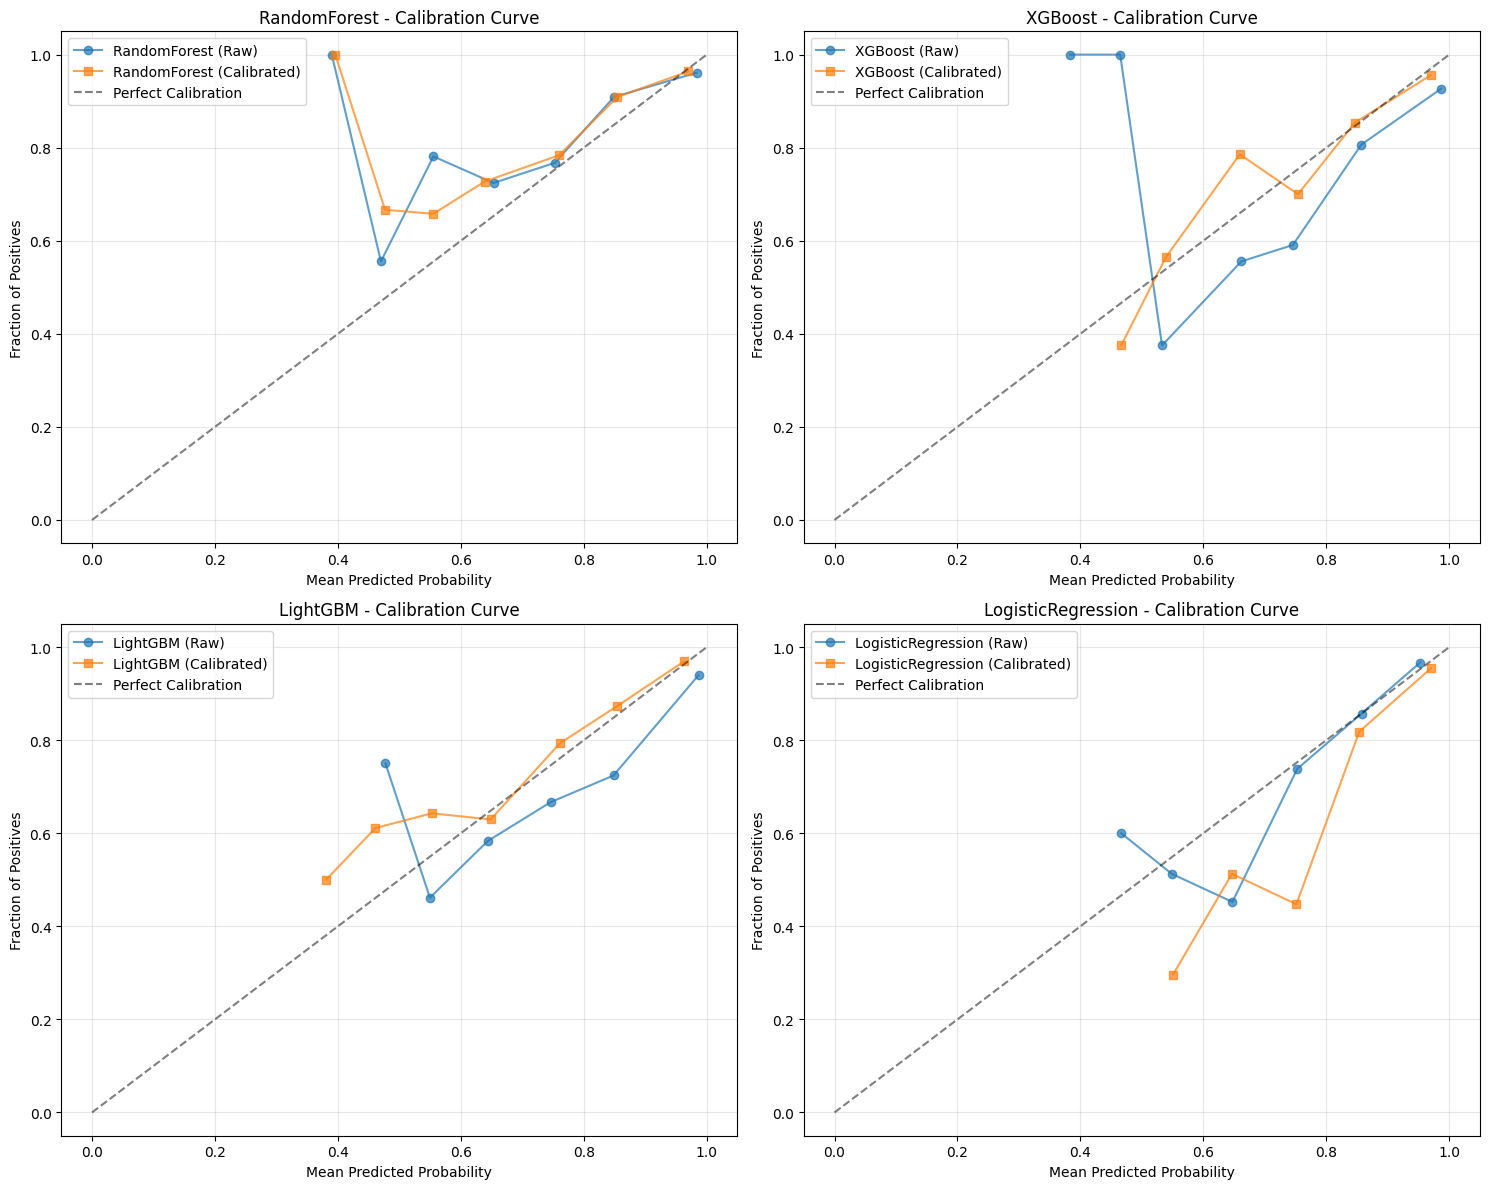

In [64]:
## Run with Isotonic regression
results_isotonic = run_calibrated_analysis(data, calibration_method='isotonic')

In [57]:

# After running your calibrated analysis and getting results
# results = run_calibrated_analysis(data, calibration_method='platt')

from results_saver import ResultsSaver
# Create saver with custom path
custom_path=path=r"C:\Users\ashish.kumar1\CSL Classification\my_ml_projects"
saver = ResultsSaver(base_path=custom_path)

In [66]:
import pickle
import joblib
import json
import numpy as np
import pandas as pd
from datetime import datetime
import os

def safe_save_results(results, experiment_name=None, base_path="ml_results_safe"):
    """
    Error-proof results saving that handles all data types safely
    """
    if experiment_name is None:
        experiment_name = f"experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    experiment_path = os.path.join(base_path, experiment_name)
    os.makedirs(experiment_path, exist_ok=True)
    
    print(f"Saving results to: {experiment_path}")
    
    for model_name, model_results in results.items():
        model_path = os.path.join(experiment_path, model_name)
        os.makedirs(model_path, exist_ok=True)
        
        print(f"  Saving {model_name}...")
        
        # 1. Save models separately using pickle (most reliable)
        try:
            with open(os.path.join(model_path, 'model.pkl'), 'wb') as f:
                pickle.dump(model_results['model'], f)
            with open(os.path.join(model_path, 'calibrated_model.pkl'), 'wb') as f:
                pickle.dump(model_results['calibrated_model'], f)
            print(f"    ✅ Models saved")
        except Exception as e:
            print(f"    ❌ Error saving models: {e}")
        
        # 2. Save numpy arrays
        try:
            np.save(os.path.join(model_path, 'predictions.npy'), model_results['predictions'])
            np.save(os.path.join(model_path, 'probabilities_raw.npy'), model_results['probabilities_raw'])
            np.save(os.path.join(model_path, 'probabilities_calibrated.npy'), model_results['probabilities_calibrated'])
            print(f"    ✅ Predictions and probabilities saved")
        except Exception as e:
            print(f"    ❌ Error saving arrays: {e}")
        
        # 3. Save basic metrics (safe)
        try:
            metrics = {
                'cv_f1_mean': float(model_results['cv_f1_mean']),
                'cv_f1_std': float(model_results['cv_f1_std']),
                'test_accuracy': float(model_results['test_accuracy']),
                'test_precision': float(model_results['test_precision']),
                'test_recall': float(model_results['test_recall']),
                'test_balanced_accuracy': float(model_results['test_balanced_accuracy']),
                'test_f1': float(model_results['test_f1']),
            }
            
            # Handle potentially missing AUC scores
            try:
                metrics['test_auc_raw'] = float(model_results.get('test_auc_raw', np.nan))
                metrics['test_auc_calibrated'] = float(model_results.get('test_auc_calibrated', np.nan))
            except:
                metrics['test_auc_raw'] = None
                metrics['test_auc_calibrated'] = None
            
            with open(os.path.join(model_path, 'metrics.json'), 'w') as f:
                json.dump(metrics, f, indent=2)
            print(f"    ✅ Basic metrics saved")
        except Exception as e:
            print(f"    ❌ Error saving metrics: {e}")
        
        # 4. Save calibration metrics (with error handling)
        try:
            cal_path = os.path.join(model_path, 'calibration')
            os.makedirs(cal_path, exist_ok=True)
            
            cal_metrics = model_results['calibration_metrics']
            
            # Safe calibration metrics
            safe_cal_metrics = {}
            for key in ['brier_score_raw', 'brier_score_calibrated', 'brier_improvement']:
                try:
                    val = cal_metrics.get(key, np.nan)
                    safe_cal_metrics[key] = float(val) if not np.isnan(val) else None
                except:
                    safe_cal_metrics[key] = None
            
            with open(os.path.join(cal_path, 'metrics.json'), 'w') as f:
                json.dump(safe_cal_metrics, f, indent=2)
            
            # Save calibration curves if they exist
            if cal_metrics.get('calibration_curve_raw') is not None:
                try:
                    curve_data = cal_metrics['calibration_curve_raw']
                    np.save(os.path.join(cal_path, 'curve_raw_frac.npy'), curve_data['fraction_positives'])
                    np.save(os.path.join(cal_path, 'curve_raw_mean.npy'), curve_data['mean_predicted'])
                except:
                    pass
            
            if cal_metrics.get('calibration_curve_calibrated') is not None:
                try:
                    curve_data = cal_metrics['calibration_curve_calibrated']
                    np.save(os.path.join(cal_path, 'curve_cal_frac.npy'), curve_data['fraction_positives'])
                    np.save(os.path.join(cal_path, 'curve_cal_mean.npy'), curve_data['mean_predicted'])
                except:
                    pass
            
            print(f"    ✅ Calibration metrics saved")
        except Exception as e:
            print(f"    ❌ Error saving calibration metrics: {e}")
        
        # 5. Save risk scores
        try:
            risk_path = os.path.join(model_path, 'risk_scores')
            os.makedirs(risk_path, exist_ok=True)
            
            risk_scores = model_results['risk_scores']
            
            # Save arrays
            np.save(os.path.join(risk_path, 'max_probability.npy'), risk_scores['max_probability'])
            np.save(os.path.join(risk_path, 'predicted_class.npy'), risk_scores['predicted_class'])
            np.save(os.path.join(risk_path, 'class_probabilities.npy'), risk_scores['class_probabilities'])
            
            # Save risk categories as CSV
            pd.Series(risk_scores['risk_category']).to_csv(
                os.path.join(risk_path, 'risk_categories.csv'), 
                index=False, header=['risk_category']
            )
            
            # Save risk performance if available
            if 'risk_performance' in risk_scores:
                safe_risk_perf = {}
                for category, metrics in risk_scores['risk_performance'].items():
                    safe_risk_perf[category] = {
                        'count': int(metrics['count']),
                        'accuracy': float(metrics['accuracy']),
                        'mean_probability': float(metrics['mean_probability'])
                    }
                
                with open(os.path.join(risk_path, 'risk_performance.json'), 'w') as f:
                    json.dump(safe_risk_perf, f, indent=2)
            
            print(f"    ✅ Risk scores saved")
        except Exception as e:
            print(f"    ❌ Error saving risk scores: {e}")
        
        # 6. Save feature importance (with maximum safety)
        try:
            feat_path = os.path.join(model_path, 'feature_importance')
            os.makedirs(feat_path, exist_ok=True)
            
            feat_importance = model_results['feature_importance']
            
            # Save each component separately with error handling
            for key, value in feat_importance.items():
                try:
                    if isinstance(value, pd.DataFrame):
                        value.to_csv(os.path.join(feat_path, f'{key}.csv'), index=False)
                    elif isinstance(value, pd.Series):
                        value.to_csv(os.path.join(feat_path, f'{key}.csv'), index=True, header=[key])
                    elif isinstance(value, np.ndarray):
                        np.save(os.path.join(feat_path, f'{key}.npy'), value)
                    elif isinstance(value, (list, dict, str, int, float, bool)):
                        with open(os.path.join(feat_path, f'{key}.json'), 'w') as f:
                            json.dump(value, f, indent=2)
                    else:
                        # Use pickle for everything else
                        with open(os.path.join(feat_path, f'{key}.pkl'), 'wb') as f:
                            pickle.dump(value, f)
                except Exception as sub_e:
                    print(f"      Warning: Could not save {key}: {sub_e}")
            
            print(f"    ✅ Feature importance saved")
        except Exception as e:
            print(f"    ❌ Error saving feature importance: {e}")
    
    # Save experiment metadata
    try:
        metadata = {
            'experiment_name': experiment_name,
            'timestamp': datetime.now().isoformat(),
            'models': list(results.keys()),
            'total_models': len(results)
        }
        
        with open(os.path.join(experiment_path, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"    ✅ Metadata saved")
    except Exception as e:
        print(f"    ❌ Error saving metadata: {e}")
    
    print(f"\n🎉 Results saved successfully to: {experiment_path}")
    return experiment_path




In [67]:
# Usage:
# Save your results
experiment_path = safe_save_results(results_isotonic,custom_path)

# Load them later
# loaded_results = safe_load_results(experiment_path)

Saving results to: C:\Users\ashish.kumar1\CSL Classification\my_ml_projects
  Saving RandomForest...
    ✅ Models saved
    ✅ Predictions and probabilities saved
    ✅ Basic metrics saved
    ✅ Calibration metrics saved
    ✅ Risk scores saved
    ✅ Feature importance saved
  Saving XGBoost...
    ✅ Models saved
    ✅ Predictions and probabilities saved
    ✅ Basic metrics saved
    ✅ Calibration metrics saved
    ✅ Risk scores saved
    ✅ Feature importance saved
  Saving LightGBM...
    ✅ Models saved
    ✅ Predictions and probabilities saved
    ✅ Basic metrics saved
    ✅ Calibration metrics saved
    ✅ Risk scores saved
    ✅ Feature importance saved
  Saving LogisticRegression...
    ✅ Models saved
    ✅ Predictions and probabilities saved
    ✅ Basic metrics saved
    ✅ Calibration metrics saved
    ✅ Risk scores saved
    ✅ Feature importance saved
  Saving GradientBoosting...
    ✅ Models saved
    ✅ Predictions and probabilities saved
    ✅ Basic metrics saved
    ✅ Calibrati

In [99]:
def predict_single_patient_risk(patient_data, trained_results, model_name='best_model'):
    """
    Predict risk score for a single patient using calibrated probabilities.
    
    Parameters:
    -----------
    patient_data : pandas.DataFrame or numpy.array
        Single patient's feature data (1 row)
    trained_results : dict
        Results from train_and_evaluate_models_with_calibration()
    model_name : str
        Name of the model to use for prediction
    
    Returns:
    --------
    dict : Comprehensive risk assessment for the patient
    """
    
    # Get the calibrated model
    if model_name == 'best_model':
        # Automatically select best performing model based on calibrated AUC
        best_model = max(trained_results.keys(), 
                        key=lambda x: trained_results[x].get('test_auc_calibrated', 0))
        model_name = best_model
    
    calibrated_model = trained_results[model_name]['calibrated_model']
    
    # Get predictions
    raw_probabilities = trained_results[model_name]['model'].predict_proba(patient_data)
    calibrated_probabilities = calibrated_model.predict_proba(patient_data)
    predicted_class = calibrated_model.predict(patient_data)
    
    # Calculate risk scores
    max_prob = np.max(calibrated_probabilities, axis=1)[0]
    predicted_class_idx = predicted_class[0]
    
    # Risk categorization
    if max_prob >= 0.8:
        risk_category = "High Risk"
        risk_description = "Strong evidence for PID - immediate clinical attention recommended"
    elif max_prob >= 0.6:
        risk_category = "Medium Risk"  
        risk_description = "Moderate evidence for PID - further evaluation recommended"
    elif max_prob >= 0.4:
        risk_category = "Low Risk"
        risk_description = "Limited evidence for PID - consider monitoring"
    else:
        risk_category = "Very Low Risk"
        risk_description = "Minimal evidence for PID - routine follow-up"
    
    # Create comprehensive risk report
    risk_report = {
        'patient_id': f"Patient_{hash(str(patient_data.iloc[0].values)) % 10000}",
        'model_used': model_name,
        
        # Main Risk Assessment
        'risk_score': round(max_prob * 100, 1),  # Convert to percentage
        'risk_category': risk_category,
        'risk_description': risk_description,
        'predicted_class': predicted_class_idx,
        
        # Detailed Probabilities
        'calibrated_probabilities': {
            f'Class_{i}': round(prob * 100, 1) 
            for i, prob in enumerate(calibrated_probabilities[0])
        },

        'raw_probabilities': {
            f'Class_{i}': round(prob * 100, 1) 
            for i, prob in enumerate(raw_probabilities[0])
        },
        
        # Clinical Interpretation
        'confidence_level': get_confidence_interpretation(max_prob),
        'recommendation': get_clinical_recommendation(max_prob, predicted_class_idx),

         ## Top 3 imp features based on impotance df 
        'top Features': trained_results[model_name]['feature_importance']['importance_df'].head(3).to_dict(orient='records'),

        
        
        # Model Performance Context
        'model_performance': {
            'model_accuracy': round(trained_results[model_name]['test_accuracy'] * 100, 1),
            'model_f1_score': round(trained_results[model_name]['test_f1'] * 100, 1),
            'calibration_quality': get_calibration_quality(trained_results[model_name]),
            'accuracy_out_of_10': get_accuracy_out_of_10(trained_results[model_name]['test_accuracy']),
            'precision_out_of_10': get_accuracy_out_of_10(trained_results[model_name]['test_precision']),
            'recall_out_of_10': get_accuracy_out_of_10(trained_results[model_name]['test_recall']),
            'balanced_accuracy': get_accuracy_out_of_10(trained_results[model_name]['test_balanced_accuracy']),
        }
    }
    
    return risk_report


def get_accuracy_out_of_10(metric_value):
    """Convert decimal accuracy/precision/recall to 'out of 10' format."""
    out_of_10 = round(metric_value * 10)
    return f"{out_of_10} out of 10"


def get_detailed_performance_interpretation(metric_value, metric_name):
    """Provide detailed interpretation of model performance metrics."""
    out_of_10 = round(metric_value * 10)
    percentage = round(metric_value * 100, 1)
    
    interpretations = {
        'accuracy': f"Correctly predicts {out_of_10} out of 10 cases overall",
        'precision': f"When predicting PID, {out_of_10} out of 10 predictions are correct",
        'recall': f"Identifies {out_of_10} out of 10 actual PID cases",
        'f1': f"Balanced performance score: {percentage}%"
    }
    
    return {
        'out_of_10': f"{out_of_10} out of 10",
        'percentage': f"{percentage}%",
        'interpretation': interpretations.get(metric_name, f"{out_of_10} out of 10")
    }
def get_confidence_interpretation(probability):
    
    """Convert probability to confidence interpretation."""
    if probability >= 0.9:
        return "Very High Confidence"
    elif probability >= 0.8:
        return "High Confidence"
    elif probability >= 0.7:
        return "Moderate Confidence"
    elif probability >= 0.6:
        return "Fair Confidence"
    else:
        return "Low Confidence"


def get_clinical_recommendation(probability, predicted_class):
    """Provide clinical recommendations based on risk score."""
    if probability >= 0.8:
        return "Immediate clinical evaluation recommended. Consider antibiotic treatment."
    elif probability >= 0.6:
        return "Further diagnostic testing recommended (e.g., pelvic exam, lab tests)."
    elif probability >= 0.4:
        return "Monitor symptoms closely. Consider follow-up if symptoms persist."
    else:
        return "Routine follow-up. Educate patient on when to seek care."


def get_calibration_quality(model_results):
    """Assess calibration quality of the model."""
    brier_improvement = model_results['calibration_metrics'].get('brier_improvement', 0)
    if brier_improvement > 0.05:
        return "Excellent calibration improvement"
    elif brier_improvement > 0.02:
        return "Good calibration improvement"
    elif brier_improvement > 0.01:
        return "Fair calibration improvement"
    else:
        return "Minimal calibration improvement"


def print_patient_risk_report(risk_report):
    """Print a formatted risk report for a patient."""
    print("="*80)
    print(f"PID RISK ASSESSMENT REPORT")
    print("="*80)
    print(f"Patient ID: {risk_report['patient_id']}")
    print(f"Model Used: {risk_report['model_used']}")
    print()
    
    print("RISK ASSESSMENT:")
    print(f"  Risk Score: {risk_report['risk_score']}%")
    print(f"  Risk Category: {risk_report['risk_category']}")
    print(f"  Confidence: {risk_report['confidence_level']}")
    print()
    
    print("CLINICAL INTERPRETATION:")
    print(f"  {risk_report['risk_description']}")
    print()
    
    print("RECOMMENDATION:")
    print(f"  {risk_report['recommendation']}")
    print()
    
    print("DETAILED PROBABILITIES:")
    print("  Calibrated Probabilities:")
    for class_name, prob in risk_report['calibrated_probabilities'].items():
        print(f"    {class_name}: {prob}%")
    print()

# Top 3 Features
    print("\n🔍 Top 3 Important Features:")
    print(f"{'Rank':<5} {'Feature':<20} {'Importance':<10}")
    print("-" * 40)
    for idx, feature in enumerate(risk_report['top Features'], start=1):
        print(f"{idx:<5} {feature['feature']:<20} {feature['importance']:<10.4f}")
    
    print("MODEL PERFORMANCE CONTEXT:")
    perf = risk_report['model_performance']
    print(f"  Model Accuracy: {perf['model_accuracy']}%")
    print(f"  Model F1-Score: {perf['model_f1_score']}%")
    print(f"  Calibration Quality: {perf['calibration_quality']}")
    print("="*80)


def batch_predict_patients(patients_data, trained_results, model_name='best_model'):
    """
    Predict risk scores for multiple patients.
    
    Parameters:
    -----------
    patients_data : pandas.DataFrame
        Multiple patients' feature data
    trained_results : dict
        Results from train_and_evaluate_models_with_calibration()
    model_name : str
        Name of the model to use for prediction
    
    Returns:
    --------
    list : List of risk reports for each patient
    """
    risk_reports = []
    
    for idx in range(len(patients_data)):
        patient_data = patients_data.iloc[idx:idx+1]  # Keep as DataFrame
        risk_report = predict_single_patient_risk(patient_data, trained_results, model_name)
        risk_report['patient_index'] = idx
        risk_reports.append(risk_report)
    
    return risk_reports


def create_risk_summary_dashboard(risk_reports):
    """Create a summary dashboard of multiple patient risk assessments."""
    import pandas as pd
    
    # Extract key metrics
    summary_data = []
    for report in risk_reports:
        summary_data.append({
            'Patient_ID': report['patient_id'],
            'Risk_Score': report['risk_score'],
            'Risk_Category': report['risk_category'],
            'Confidence': report['confidence_level'],
            'Predicted_Class': report['predicted_class']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Risk distribution
    risk_distribution = summary_df['Risk_Category'].value_counts()
    
    print("PATIENT RISK SUMMARY DASHBOARD")
    print("="*60)
    print(f"Total Patients Assessed: {len(risk_reports)}")
    print()
    print("Risk Distribution:")
    for category, count in risk_distribution.items():
        percentage = (count / len(risk_reports)) * 100
        print(f"  {category}: {count} patients ({percentage:.1f}%)")
    print()
    
    print("High Risk Patients (≥80% risk score):")
    high_risk = summary_df[summary_df['Risk_Score'] >= 80]
    if len(high_risk) > 0:
        for _, patient in high_risk.iterrows():
            print(f"  {patient['Patient_ID']}: {patient['Risk_Score']}% risk")
    else:
        print("  No high-risk patients identified")
    
    return summary_df

In [100]:
#get the best model out of the all model based on balace accuracy 
best_model_name = max(results_isotonic.keys(),
                       key=lambda x: results_isotonic[x]['test_balanced_accuracy'])
best_model_name

'LogisticRegression'

In [101]:
## get best three imp features based on score
results_isotonic[best_model_name]['feature_importance']['importance_df']

,feature,importance
9,PX_STEM_CELL_TRANSPLANT,2.734733
7,MED_CYTOTOXIC_CHEMOTHERAPY,2.680039
4,CD_HEMATOLOGIC_MALIGNANCIES,2.642912
3,CD_HIV_AIDS,1.993917
6,MED_CORTICOSTEROIDS,1.969054
8,MED_MONOCLONAL_ANTIBODIES,1.782908
2,FH_SCID,1.034805
1,FH_CVID,0.951882
15,Calculated Globulin,0.882373
10,IF_LUNG_ABSCESS,0.829879


In [98]:
# Reshape the array to be 2D (1 row x n columns)
patient_data = pd.DataFrame(data['X_test'][3].reshape(1, -1), columns=feature_names)
patient_data.to_csv('single_patient_data.csv', index=False)
predict_single_patient_risk(patient_data, results_isotonic, model_name=best_model_name)

{'patient_id': 'Patient_3886',
 'model_used': 'LogisticRegression',
 'risk_score': np.float64(97.2),
 'risk_category': 'High Risk',
 'risk_description': 'Strong evidence for PID - immediate clinical attention recommended',
 'predicted_class': np.int64(0),
 'calibrated_probabilities': {'Class_0': np.float64(97.2),
  'Class_1': np.float64(2.8),
  'Class_2': np.float64(0.0)},
 'raw_probabilities': {'Class_0': np.float64(87.3),
  'Class_1': np.float64(11.6),
  'Class_2': np.float64(1.1)},
 'confidence_level': 'Very High Confidence',
 'recommendation': 'Immediate clinical evaluation recommended. Consider antibiotic treatment.',
 'top Features': [{'feature': 'PX_STEM_CELL_TRANSPLANT',
   'importance': 2.7347331804581523},
  {'feature': 'MED_CYTOTOXIC_CHEMOTHERAPY', 'importance': 2.680039046828346},
  {'feature': 'CD_HEMATOLOGIC_MALIGNANCIES', 'importance': 2.642911822075066}],
 'model_performance': {'model_accuracy': 80.0,
  'model_f1_score': 74.3,
  'calibration_quality': 'Minimal calibrati

### Try Ensemble Codes

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import shap

# Global flag for SHAP availability
SHAP_AVAILABLE = True

def initialize_ensemble_models(base_models, random_state=42, categorical_feature_indices=None):
    """
    Initialize ensemble models using the base models.
    
    Parameters:
    -----------
    base_models : dict
        Dictionary of base models
    random_state : int
        Random state for reproducibility
    categorical_feature_indices : list
        Indices of categorical features (for CatBoost)
    
    Returns:
    --------
    dict : Dictionary of ensemble models
    """
    ensemble_models = {}
    
    # Prepare estimators for voting (exclude CatBoost for standard voting)
    voting_estimators = [(name, model) for name, model in base_models.items() 
                        if name != 'CatBoost']
    
    if len(voting_estimators) >= 2:
        # Soft Voting Classifier
        ensemble_models['VotingClassifier_Soft'] = VotingClassifier(
            estimators=voting_estimators,
            voting='soft'
        )
        
        # Hard Voting Classifier
        ensemble_models['VotingClassifier_Hard'] = VotingClassifier(
            estimators=voting_estimators,
            voting='hard'
        )
    
    # Bagging with different base estimators
    if 'RandomForest' in base_models:
        ensemble_models['Bagging_RF'] = BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=random_state),
            n_estimators=50,
            random_state=random_state
        )
    
    # AdaBoost
    ensemble_models['AdaBoost'] = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=random_state),
        n_estimators=50,
        random_state=random_state
    )
    
    # Stacking Classifier
    if len(voting_estimators) >= 2:
        ensemble_models['StackingClassifier'] = StackingClassifier(
            estimators=voting_estimators,
            final_estimator=LogisticRegression(random_state=random_state, max_iter=1000),
            cv=5
        )
    
    return ensemble_models

def get_ensemble_feature_importance(model, model_name, X_train, feature_names, 
                                  use_shap=False, max_samples=100):
    """
    Extract feature importance from ensemble models.
    
    Parameters:
    -----------
    model : trained ensemble model
        The fitted ensemble model
    model_name : str
        Name of the ensemble model
    X_train : DataFrame or array
        Training data for SHAP calculations
    feature_names : list
        List of feature names
    use_shap : bool
        Whether to use SHAP values for feature importance
    max_samples : int
        Maximum samples to use for SHAP calculation
    
    Returns:
    --------
    dict : Dictionary containing feature importance information
    """
    importance_info = {}
    
    # SHAP analysis for ensemble models
    if use_shap and SHAP_AVAILABLE:
        try:
            # Sample data for SHAP if dataset is large
            if len(X_train) > max_samples:
                sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
                X_sample = X_train.iloc[sample_idx] if hasattr(X_train, 'iloc') else X_train[sample_idx]
            else:
                X_sample = X_train
            
            # Use general explainer for ensemble models
            explainer = shap.Explainer(model, X_sample)
            shap_values = explainer.shap_values(X_sample)
            
            # Handle multiclass case
            if len(shap_values.shape) == 3:  # multiclass
                importance_values = np.mean(np.abs(shap_values), axis=(0, 2))
            else:
                importance_values = np.mean(np.abs(shap_values), axis=0)
            
            importance_info['shap_importance'] = importance_values
            importance_info['shap_values'] = shap_values
            
        except Exception as e:
            print(f"SHAP calculation failed for {model_name}: {str(e)}")
            importance_info['shap_importance'] = None
    
    # Extract feature importance from ensemble models
    if 'Voting' in model_name:
        # Average feature importance from all estimators in voting classifier
        importances = []
        valid_estimators = []
        
        for name, estimator in model.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
                valid_estimators.append(name)
            elif name == 'LogisticRegression':
                if len(estimator.coef_.shape) > 1:  # multiclass
                    importances.append(np.mean(np.abs(estimator.coef_), axis=0))
                else:
                    importances.append(np.abs(estimator.coef_[0]))
                valid_estimators.append(name)
        
        if importances:
            importance_info['builtin_importance'] = np.mean(importances, axis=0)
            importance_info['individual_importances'] = {
                name: imp for name, imp in zip(valid_estimators, importances)
            }
    
    elif 'Stacking' in model_name:
        # Get importance from the final estimator and base estimators
        importances = []
        valid_estimators = []
        
        # Base estimators
        for name, estimator in model.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
                valid_estimators.append(f"base_{name}")
        
        if importances:
            importance_info['base_estimators_importance'] = np.mean(importances, axis=0)
        
        # Final estimator importance (meta-learner)
        final_est = model.final_estimator_
        if hasattr(final_est, 'coef_'):
            if len(final_est.coef_.shape) > 1:
                meta_importance = np.mean(np.abs(final_est.coef_), axis=0)
            else:
                meta_importance = np.abs(final_est.coef_[0])
            importance_info['meta_learner_importance'] = meta_importance
        
        # Use base estimators average as main importance
        importance_info['builtin_importance'] = importance_info.get('base_estimators_importance')
    
    elif hasattr(model, 'feature_importances_'):
        # For Bagging, AdaBoost, etc.
        importance_info['builtin_importance'] = model.feature_importances_
    
    # Create feature importance DataFrames
    if importance_info.get('builtin_importance') is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_info['builtin_importance']
        }).sort_values('importance', ascending=False)
        importance_info['importance_df'] = importance_df
    
    if importance_info.get('shap_importance') is not None:
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': importance_info['shap_importance']
        }).sort_values('shap_importance', ascending=False)
        importance_info['shap_df'] = shap_df
    
    return importance_info

def get_feature_importance(model, model_name, X_train, feature_names, use_shap=False, max_samples=100):
    """
    Extract feature importance from models using built-in methods or SHAP values.
    Enhanced to handle both individual and ensemble models.
    
    Parameters:
    -----------
    model : trained model
        The fitted model
    model_name : str
        Name of the model
    X_train : DataFrame or array
        Training data for SHAP calculations
    feature_names : list
        List of feature names
    use_shap : bool
        Whether to use SHAP values for feature importance
    max_samples : int
        Maximum samples to use for SHAP calculation (for performance)
    
    Returns:
    --------
    dict : Dictionary containing feature importance information
    """
    # Check if it's an ensemble model
    ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
    if any(keyword in model_name for keyword in ensemble_keywords):
        return get_ensemble_feature_importance(model, model_name, X_train, feature_names, 
                                             use_shap, max_samples)
    
    # Original logic for individual models
    importance_info = {}
    
    if use_shap and SHAP_AVAILABLE:
        try:
            # Sample data for SHAP if dataset is large
            if len(X_train) > max_samples:
                sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
                X_sample = X_train.iloc[sample_idx] if hasattr(X_train, 'iloc') else X_train[sample_idx]
            else:
                X_sample = X_train
            
            # Choose appropriate SHAP explainer based on model type
            if model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']:
                explainer = shap.TreeExplainer(model)
            elif model_name == 'CatBoost':
                explainer = shap.TreeExplainer(model)
            elif model_name == 'LogisticRegression':
                explainer = shap.LinearExplainer(model, X_sample)
            else:
                explainer = shap.Explainer(model, X_sample)
            
            shap_values = explainer.shap_values(X_sample)
            
            # Handle multiclass case
            if len(shap_values.shape) == 3:  # multiclass
                # Use mean absolute SHAP values across classes
                importance_values = np.mean(np.abs(shap_values), axis=(0, 2))
            else:
                importance_values = np.mean(np.abs(shap_values), axis=0)
            
            importance_info['shap_importance'] = importance_values
            importance_info['shap_values'] = shap_values
            
        except Exception as e:
            print(f"SHAP calculation failed for {model_name}: {str(e)}")
            importance_info['shap_importance'] = None
    
    # Built-in feature importance
    if hasattr(model, 'feature_importances_'):
        importance_info['builtin_importance'] = model.feature_importances_
    elif model_name == 'CatBoost':
        importance_info['builtin_importance'] = model.get_feature_importance()
    elif model_name == 'LogisticRegression':
        # Use absolute values of coefficients as importance
        if len(model.coef_.shape) > 1:  # multiclass
            importance_info['builtin_importance'] = np.mean(np.abs(model.coef_), axis=0)
        else:
            importance_info['builtin_importance'] = np.abs(model.coef_[0])
    else:
        importance_info['builtin_importance'] = None
    
    # Create feature importance DataFrame
    if importance_info.get('builtin_importance') is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_info['builtin_importance']
        }).sort_values('importance', ascending=False)
        importance_info['importance_df'] = importance_df
    
    if importance_info.get('shap_importance') is not None:
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': importance_info['shap_importance']
        }).sort_values('shap_importance', ascending=False)
        importance_info['shap_df'] = shap_df
    
    return importance_info

def train_and_evaluate_models(data, models=None, cv_folds=5, random_state=42, 
                            use_shap=False, shap_max_samples=100, include_ensemble=True):
    """
    Train and evaluate all models using cross-validation.
    Handles CatBoost separately due to its categorical feature requirements.
    Now includes ensemble methods.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing train/test splits and feature information
    models : dict
        Dictionary of models to train
    cv_folds : int
        Number of cross-validation folds
    random_state : int
        Random state for reproducibility
    use_shap : bool
        Whether to calculate SHAP feature importance
    shap_max_samples : int
        Maximum samples for SHAP calculation
    include_ensemble : bool
        Whether to include ensemble methods
    """
    if not models:
        models = initialize_models(random_state=random_state, 
                                 categorical_feature_indices=data.get('categorical_feature_indices'))

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    feature_names = data['feature_names']
    X_train_catboost = data['X_train_catboost']
    X_test_catboost = data['X_test_catboost']
    cat_features = data['categorical_feature_indices']
    
    # Add ensemble models if requested
    if include_ensemble:
        print("Initializing ensemble models...")
        ensemble_models = initialize_ensemble_models(models, random_state, cat_features)
        models.update(ensemble_models)
        print(f"Added {len(ensemble_models)} ensemble models: {list(ensemble_models.keys())}")
    
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use appropriate data based on model type
        if name == 'CatBoost':
            X_train_model = X_train_catboost
            X_test_model = X_test_catboost
            
            # Cross-validation for CatBoost
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train_model, y_train):
                X_cv_train, X_cv_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
                y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                
                model_cv = CatBoostClassifier(
                    random_state=random_state,
                    verbose=False,
                    iterations=500,
                    cat_features=cat_features,
                    train_dir=None
                )
                model_cv.fit(X_cv_train, y_cv_train)
                y_pred_cv = model_cv.predict(X_cv_val)
                cv_scores.append(f1_score(y_cv_val, y_pred_cv, average='macro'))
            
            cv_scores = np.array(cv_scores)
            
            # Fit final model
            model.fit(X_train_model, y_train)
            y_pred = model.predict(X_test_model)
            y_pred_proba = model.predict_proba(X_test_model)
            
        else:
            X_train_model = X_train
            X_test_model = X_test
            
            # Cross-validation scores
            try:
                cv_scores = cross_val_score(model, X_train_model, y_train, 
                                          cv=cv, scoring='f1_macro')
            except Exception as e:
                print(f"Cross-validation failed for {name}: {str(e)}")
                # Fallback to simple train-validation split
                from sklearn.model_selection import train_test_split
                X_cv_train, X_cv_val, y_cv_train, y_cv_val = train_test_split(
                    X_train_model, y_train, test_size=0.2, random_state=random_state, 
                    stratify=y_train
                )
                temp_model = type(model)(**model.get_params()) if hasattr(model, 'get_params') else model
                temp_model.fit(X_cv_train, y_cv_train)
                y_cv_pred = temp_model.predict(X_cv_val)
                cv_scores = np.array([f1_score(y_cv_val, y_cv_pred, average='macro')])
            
            # Fit model
            model.fit(X_train_model, y_train)
            y_pred = model.predict(X_test_model)
            if hasattr(model, 'predict_proba'):
                # Use predict_proba if available
                y_pred_proba = model.predict_proba(X_test_model)
        
        # Calculate metrics
        results[name] = {
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_precision': precision_score(y_test, y_pred, average='macro'),
            'test_recall': recall_score(y_test, y_pred, average='macro'),
            'test_f1': f1_score(y_test, y_pred, average='macro'),
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'model': model  # Store the trained model
        }
        
        # ROC AUC for multiclass
        try:
            results[name]['test_auc_raw'] = roc_auc_score(y_test, y_pred_proba, 
                                                    multi_class='ovr', average='macro')
        except:
            results[name]['test_auc_raw'] = np.nan
        
        # Feature importance analysis
        print(f"Calculating feature importance for {name}...")
        try:
            importance_info = get_feature_importance(
                model, name, X_train_model, feature_names, 
                use_shap=use_shap, max_samples=shap_max_samples
            )
            results[name]['feature_importance'] = importance_info
        except Exception as e:
            print(f"Feature importance calculation failed for {name}: {str(e)}")
            results[name]['feature_importance'] = None
    
    return results


def display_ensemble_results(results, top_n=10):
    """
    Display results with special formatting for ensemble methods.
    """
    # Create results DataFrame
    results_df = pd.DataFrame({
        name: {
            'CV F1 (mean±std)': f"{res['cv_f1_mean']:.4f}±{res['cv_f1_std']:.4f}",
            'Test Accuracy': f"{res['test_accuracy']:.4f}",
            'Test F1': f"{res['test_f1']:.4f}",
            'Test AUC': f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A'
        }
        for name, res in results.items()
    }).T
    
    # Sort by test F1 score
    f1_scores = [results[name]['test_f1'] for name in results.keys()]
    sorted_indices = np.argsort(f1_scores)[::-1]
    sorted_names = [list(results.keys())[i] for i in sorted_indices]
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    
    # Separate individual and ensemble models
    individual_models = []
    ensemble_models = []
    
    for name in sorted_names:
        ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
        if any(keyword in name for keyword in ensemble_keywords):
            ensemble_models.append(name)
        else:
            individual_models.append(name)
    
    print("\nINDIVIDUAL MODELS:")
    print("-" * 50)
    for name in individual_models:
        res = results[name]
        auc_val = f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A'
        print(f"{name:20s} | F1: {res['test_f1']:.4f} | Acc: {res['test_accuracy']:.4f} | AUC: {auc_val:>6}")
    
    if ensemble_models:
        print("\nENSEMBLE MODELS:")
        print("-" * 50)
        for name in ensemble_models:
            res = results[name]
            auc_val = f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A'
            print(f"{name:20s} | F1: {res['test_f1']:.4f} | Acc: {res['test_accuracy']:.4f} | AUC: {auc_val:>6}")
    
    print(f"\nTOP {top_n} PERFORMING MODELS:")
    print("-" * 50)
    for i, name in enumerate(sorted_names[:top_n]):
        res = results[name]
        rank_symbol = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else f"{i+1:2d}."
        print(f"{rank_symbol} {name:20s} | F1: {res['test_f1']:.4f}")
    
    return results_df.loc[sorted_names]

In [16]:
##take only two models from base models to check
check_models = {k: base_models[k] for k in list(base_models.keys())[:2]}

In [15]:
# Your existing usage, but now with ensembles
results = train_and_evaluate_models(
    data=data,
    models=check_models,  # Your existing models
    cv_folds=5,
    random_state=42,
    use_shap=True,
    include_ensemble=True  # New parameter
)

Initializing ensemble models...
Added 5 ensemble models: ['VotingClassifier_Soft', 'VotingClassifier_Hard', 'Bagging_RF', 'AdaBoost', 'StackingClassifier']

Training RandomForest...
Calculating feature importance for RandomForest...

Training XGBoost...
Calculating feature importance for XGBoost...

Training LightGBM...
Calculating feature importance for LightGBM...

Training VotingClassifier_Soft...
Calculating feature importance for VotingClassifier_Soft...
SHAP calculation failed for VotingClassifier_Soft: The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                  

In [19]:
results['VotingClassifier_Soft']['feature_importance']

{'shap_importance': None,
 'builtin_importance': array([  66.68144257,   56.04530464,   23.01466291,   57.04177159,
          43.3974265 ,   48.6801474 ,   81.04063902,   46.3926993 ,
          84.03984387,   40.06929502,   29.01303551,   52.01952835,
          84.36050292,   86.02714028, 1107.727813  , 1089.78208048]),
 'individual_importances': {'RandomForest': array([0.02044475, 0.05620955, 0.00710326, 0.04600331, 0.0591019 ,
         0.01468734, 0.0603504 , 0.0560576 , 0.04572463, 0.0530611 ,
         0.00962349, 0.02430877, 0.03784555, 0.03658839, 0.16543002,
         0.30745995]),
  'XGBoost': array([0.02388296, 0.07970436, 0.03688546, 0.07931145, 0.1331776 ,
         0.02575487, 0.06156665, 0.12204029, 0.07380697, 0.15482397,
         0.02948305, 0.03427627, 0.04366322, 0.04483244, 0.01800897,
         0.03878151], dtype=float32),
  'LightGBM': array([ 200,  168,   69,  171,  130,  146,  243,  139,  252,  120,   87,
          156,  253,  258, 3323, 3269], dtype=int32)},
 'import

In [21]:
# Display results with ensemble-aware formatting
results_df = display_ensemble_results(results, top_n=10)


MODEL PERFORMANCE COMPARISON

INDIVIDUAL MODELS:
--------------------------------------------------
RandomForest         | F1: 0.8166 | Acc: 0.8925 | AUC: 0.9362
XGBoost              | F1: 0.8033 | Acc: 0.8800 | AUC: 0.9389
LightGBM             | F1: 0.8029 | Acc: 0.8775 | AUC: 0.9447

ENSEMBLE MODELS:
--------------------------------------------------
VotingClassifier_Soft | F1: 0.8232 | Acc: 0.8925 | AUC: 0.9442
StackingClassifier   | F1: 0.8157 | Acc: 0.8900 | AUC: 0.9380
VotingClassifier_Hard | F1: 0.8086 | Acc: 0.8850 | AUC: 0.9442
Bagging_RF           | F1: 0.7726 | Acc: 0.8700 | AUC: 0.9320
AdaBoost             | F1: 0.5862 | Acc: 0.8150 | AUC: 0.8943

TOP 10 PERFORMING MODELS:
--------------------------------------------------
🥇 VotingClassifier_Soft | F1: 0.8232
🥈 RandomForest         | F1: 0.8166
🥉 StackingClassifier   | F1: 0.8157
 4. VotingClassifier_Hard | F1: 0.8086
 5. XGBoost              | F1: 0.8033
 6. LightGBM             | F1: 0.8029
 7. Bagging_RF           | F1:

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame({
    name: {
        'CV F1 (mean±std)': f"{res['cv_f1_mean']:.4f}±{res['cv_f1_std']:.4f}",
        'Test Accuracy': f"{res['test_accuracy']:.4f}",
        'Test F1': f"{res['test_f1']:.4f}",
        'Test AUC': f"{res['test_auc']:.4f}" if not np.isnan(res['test_auc']) else 'N/A'
    }
    for name, res in results.items()
}).T

In [25]:
results_df

,CV F1 (mean±std),Test Accuracy,Test F1,Test AUC
RandomForest,0.7542±0.0308,0.8925,0.8166,0.9362
XGBoost,0.7881±0.0054,0.8800,0.8033,0.9389
VotingClassifier_Soft,0.7902±0.0164,0.8775,0.7947,0.9403
VotingClassifier_Hard,0.7528±0.0313,0.8925,0.8130,0.9403
Bagging_RF,0.7462±0.0287,0.8700,0.7726,0.9320
AdaBoost,0.5929±0.0326,0.8150,0.5862,0.8943
StackingClassifier,0.7836±0.0152,0.8825,0.7994,0.9350


In [ ]:
model_test=results['RandomForest']['model']
explainer=shap.TreeExplainer(model_test)
shap_values = explainer.shap_values(X_train)

### Ensemble with Calibration

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.base import clone
import warnings
# Global flag for SHAP availability
SHAP_AVAILABLE = True

def initialize_ensemble_models(base_models, random_state=42, categorical_feature_indices=None):
    """
    Initialize ensemble models using the base models.
    
    Parameters:
    -----------
    base_models : dict
        Dictionary of base models
    random_state : int
        Random state for reproducibility
    categorical_feature_indices : list
        Indices of categorical features (for CatBoost)
    
    Returns:
    --------
    dict : Dictionary of ensemble models
    """
    ensemble_models = {}
    
    # Prepare estimators for voting (exclude CatBoost for standard voting)
    voting_estimators = [(name, model) for name, model in base_models.items() 
                        if name != 'CatBoost']
    
    if len(voting_estimators) >= 2:
        # Soft Voting Classifier
        ensemble_models['VotingClassifier_Soft'] = VotingClassifier(
            estimators=voting_estimators,
            voting='soft'
        )
        
        # Hard Voting Classifier (optional)
        ensemble_models['VotingClassifier_Hard'] = VotingClassifier(
            estimators=voting_estimators,
            voting='hard'
        )
    
    # Bagging with different base estimators
    if 'RandomForest' in base_models:
        ensemble_models['Bagging_RF'] = BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=random_state),
            n_estimators=50,
            random_state=random_state
        )
    
    # AdaBoost
    ensemble_models['AdaBoost'] = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=random_state),
        n_estimators=50,
        random_state=random_state
    )
    
    # Stacking Classifier
    if len(voting_estimators) >= 2:
        ensemble_models['StackingClassifier'] = StackingClassifier(
            estimators=voting_estimators,
            final_estimator=LogisticRegression(random_state=random_state, max_iter=1000),
            cv=5
        )
    
    return ensemble_models

def get_ensemble_feature_importance(model, model_name, X_train, feature_names, 
                                  use_shap=False, max_samples=100):
    """
    Extract feature importance from ensemble models.
    
    Parameters:
    -----------
    model : trained ensemble model
        The fitted ensemble model
    model_name : str
        Name of the ensemble model
    X_train : DataFrame or array
        Training data for SHAP calculations
    feature_names : list
        List of feature names
    use_shap : bool
        Whether to use SHAP values for feature importance
    max_samples : int
        Maximum samples to use for SHAP calculation
    
    Returns:
    --------
    dict : Dictionary containing feature importance information
    """
    importance_info = {}
    
    # SHAP analysis for ensemble models
    if use_shap and SHAP_AVAILABLE:
        try:
            # Sample data for SHAP if dataset is large
            if len(X_train) > max_samples:
                sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
                X_sample = X_train.iloc[sample_idx] if hasattr(X_train, 'iloc') else X_train[sample_idx]
            else:
                X_sample = X_train
            
            # Use general explainer for ensemble models
            explainer = shap.Explainer(model, X_sample)
            shap_values = explainer.shap_values(X_sample)
            
            # Handle multiclass case
            if len(shap_values.shape) == 3:  # multiclass
                importance_values = np.mean(np.abs(shap_values), axis=(0, 2))
            else:
                importance_values = np.mean(np.abs(shap_values), axis=0)
            
            importance_info['shap_importance'] = importance_values
            importance_info['shap_values'] = shap_values
            
        except Exception as e:
            print(f"SHAP calculation failed for {model_name}: {str(e)}")
            importance_info['shap_importance'] = None
    
    # Extract feature importance from ensemble models
    if 'Voting' in model_name:
        # Average feature importance from all estimators in voting classifier
        importances = []
        valid_estimators = []
        
        for name, estimator in model.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
                valid_estimators.append(name)
            elif name == 'LogisticRegression':
                if len(estimator.coef_.shape) > 1:  # multiclass
                    importances.append(np.mean(np.abs(estimator.coef_), axis=0))
                else:
                    importances.append(np.abs(estimator.coef_[0]))
                valid_estimators.append(name)
        
        if importances:
            importance_info['builtin_importance'] = np.mean(importances, axis=0)
            importance_info['individual_importances'] = {
                name: imp for name, imp in zip(valid_estimators, importances)
            }
    
    elif 'Stacking' in model_name:
        # Get importance from the final estimator and base estimators
        importances = []
        valid_estimators = []
        
        # Base estimators
        for name, estimator in model.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                importances.append(estimator.feature_importances_)
                valid_estimators.append(f"base_{name}")
        
        if importances:
            importance_info['base_estimators_importance'] = np.mean(importances, axis=0)
        
        # Final estimator importance (meta-learner)
        final_est = model.final_estimator_
        if hasattr(final_est, 'coef_'):
            if len(final_est.coef_.shape) > 1:
                meta_importance = np.mean(np.abs(final_est.coef_), axis=0)
            else:
                meta_importance = np.abs(final_est.coef_[0])
            importance_info['meta_learner_importance'] = meta_importance
        
        # Use base estimators average as main importance
        importance_info['builtin_importance'] = importance_info.get('base_estimators_importance')
    
    elif hasattr(model, 'feature_importances_'):
        # For Bagging, AdaBoost, etc.
        importance_info['builtin_importance'] = model.feature_importances_
    
    # Create feature importance DataFrames
    if importance_info.get('builtin_importance') is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_info['builtin_importance']
        }).sort_values('importance', ascending=False)
        importance_info['importance_df'] = importance_df
    
    if importance_info.get('shap_importance') is not None:
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': importance_info['shap_importance']
        }).sort_values('shap_importance', ascending=False)
        importance_info['shap_df'] = shap_df
    
    return importance_info

def get_feature_importance(model, model_name, X_train, feature_names, use_shap=False, max_samples=100):
    """
    Extract feature importance from models using built-in methods or SHAP values.
    Enhanced to handle both individual and ensemble models.
    
    Parameters:
    -----------
    model : trained model
        The fitted model
    model_name : str
        Name of the model
    X_train : DataFrame or array
        Training data for SHAP calculations
    feature_names : list
        List of feature names
    use_shap : bool
        Whether to use SHAP values for feature importance
    max_samples : int
        Maximum samples to use for SHAP calculation (for performance)
    
    Returns:
    --------
    dict : Dictionary containing feature importance information
    """
    # Check if it's an ensemble model
    ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
    if any(keyword in model_name for keyword in ensemble_keywords):
        return get_ensemble_feature_importance(model, model_name, X_train, feature_names, 
                                             use_shap, max_samples)
    
    # Original logic for individual models
    importance_info = {}
    
    if use_shap and SHAP_AVAILABLE:
        try:
            # Sample data for SHAP if dataset is large
            if len(X_train) > max_samples:
                sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
                X_sample = X_train.iloc[sample_idx] if hasattr(X_train, 'iloc') else X_train[sample_idx]
            else:
                X_sample = X_train
            
            # Choose appropriate SHAP explainer based on model type
            if model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']:
                explainer = shap.TreeExplainer(model)
            elif model_name == 'CatBoost':
                explainer = shap.TreeExplainer(model)
            elif model_name == 'LogisticRegression':
                explainer = shap.LinearExplainer(model, X_sample)
            else:
                explainer = shap.Explainer(model, X_sample)
            
            shap_values = explainer.shap_values(X_sample)
            
            # Handle multiclass case
            if len(shap_values.shape) == 3:  # multiclass
                # Use mean absolute SHAP values across classes
                importance_values = np.mean(np.abs(shap_values), axis=(0, 2))
            else:
                importance_values = np.mean(np.abs(shap_values), axis=0)
            
            importance_info['shap_importance'] = importance_values
            importance_info['shap_values'] = shap_values
            
        except Exception as e:
            print(f"SHAP calculation failed for {model_name}: {str(e)}")
            importance_info['shap_importance'] = None
    
    # Built-in feature importance
    if hasattr(model, 'feature_importances_'):
        importance_info['builtin_importance'] = model.feature_importances_
    elif model_name == 'CatBoost':
        importance_info['builtin_importance'] = model.get_feature_importance()
    elif model_name == 'LogisticRegression':
        # Use absolute values of coefficients as importance
        if len(model.coef_.shape) > 1:  # multiclass
            importance_info['builtin_importance'] = np.mean(np.abs(model.coef_), axis=0)
        else:
            importance_info['builtin_importance'] = np.abs(model.coef_[0])
    else:
        importance_info['builtin_importance'] = None
    
    # Create feature importance DataFrame
    if importance_info.get('builtin_importance') is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_info['builtin_importance']
        }).sort_values('importance', ascending=False)
        importance_info['importance_df'] = importance_df
    
    if importance_info.get('shap_importance') is not None:
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': importance_info['shap_importance']
        }).sort_values('shap_importance', ascending=False)
        importance_info['shap_df'] = shap_df
    
    return importance_info

def calculate_calibration_metrics(y_true, y_prob_raw, y_prob_calibrated):
    """
    Calculate calibration metrics comparing raw vs calibrated probabilities.
    """
    calibration_metrics = {}
    
    # For multiclass, we'll focus on the positive class or highest probability class
    if y_prob_raw.shape[1] > 2:
        # For multiclass, use the max probability approach
        y_prob_raw_max = np.max(y_prob_raw, axis=1)
        y_prob_cal_max = np.max(y_prob_calibrated, axis=1)
        y_true_binary = (np.argmax(y_prob_raw, axis=1) == y_true).astype(int)
    else:
        # For binary classification
        y_prob_raw_max = y_prob_raw[:, 1]
        y_prob_cal_max = y_prob_calibrated[:, 1]
        y_true_binary = y_true
    
    # Brier Score (lower is better)
    try:
        brier_raw = brier_score_loss(y_true_binary, y_prob_raw_max)
        brier_calibrated = brier_score_loss(y_true_binary, y_prob_cal_max)
        calibration_metrics['brier_score_raw'] = brier_raw
        calibration_metrics['brier_score_calibrated'] = brier_calibrated
        calibration_metrics['brier_improvement'] = brier_raw - brier_calibrated
    except:
        calibration_metrics['brier_score_raw'] = np.nan
        calibration_metrics['brier_score_calibrated'] = np.nan
        calibration_metrics['brier_improvement'] = np.nan
    
    # Calibration curve data
    try:
        fraction_pos_raw, mean_pred_raw = calibration_curve(
            y_true_binary, y_prob_raw_max, n_bins=10
        )
        fraction_pos_cal, mean_pred_cal = calibration_curve(
            y_true_binary, y_prob_cal_max, n_bins=10
        )
        
        calibration_metrics['calibration_curve_raw'] = {
            'fraction_positives': fraction_pos_raw,
            'mean_predicted': mean_pred_raw
        }
        calibration_metrics['calibration_curve_calibrated'] = {
            'fraction_positives': fraction_pos_cal,
            'mean_predicted': mean_pred_cal
        }
    except:
        calibration_metrics['calibration_curve_raw'] = None
        calibration_metrics['calibration_curve_calibrated'] = None
    
    return calibration_metrics

def calculate_risk_scores(y_prob_calibrated, y_true=None):
    """
    Calculate interpretable risk scores from calibrated probabilities.
    """
    risk_scores = {}
    
    # Maximum class probability as primary risk score
    max_prob = np.max(y_prob_calibrated, axis=1)
    predicted_class = np.argmax(y_prob_calibrated, axis=1)
    
    # Risk categories based on probability thresholds
    risk_categories = np.where(
        max_prob >= 0.8, 'High Risk',
        np.where(max_prob >= 0.6, 'Medium Risk',
                np.where(max_prob >= 0.4, 'Low Risk', 'Very Low Risk'))
    )
    
    risk_scores['max_probability'] = max_prob
    risk_scores['predicted_class'] = predicted_class
    risk_scores['risk_category'] = risk_categories
    risk_scores['class_probabilities'] = y_prob_calibrated
    
    # If we have true labels, calculate risk score performance
    if y_true is not None:
        # Risk score accuracy by category
        risk_performance = {}
        for category in np.unique(risk_categories):
            mask = risk_categories == category
            if np.sum(mask) > 0:
                accuracy = accuracy_score(y_true[mask], predicted_class[mask])
                risk_performance[category] = {
                    'count': np.sum(mask),
                    'accuracy': accuracy,
                    'mean_probability': np.mean(max_prob[mask])
                }
        
        risk_scores['risk_performance'] = risk_performance
    
    return risk_scores

def is_calibration_compatible(model):
    """
    Check if a model is compatible with CalibratedClassifierCV.
    
    Parameters:
    -----------
    model : sklearn estimator
        The model to check
        
    Returns:
    --------
    bool : True if compatible, False otherwise
    """
    # Check if model has predict_proba or decision_function
    has_predict_proba = hasattr(model, 'predict_proba')
    has_decision_function = hasattr(model, 'decision_function')
    
    # VotingClassifier with 'hard' voting doesn't have predict_proba
    if hasattr(model, 'voting') and model.voting == 'hard':
        return False
    
    # Some ensemble models may have issues
    problematic_models = ['AdaBoostClassifier', 'BaggingClassifier']
    model_name = type(model).__name__
    
    if model_name in problematic_models:
        # Test if predict_proba actually works
        try:
            # Create a simple test to see if predict_proba works properly
            return has_predict_proba
        except:
            return False
    
    return has_predict_proba or has_decision_function

def safe_calibrate_model(model, X_train, y_train, calibration_method='isotonic', cv=3):
    """
    Safely calibrate a model, handling cases where calibration might fail.
    
    Parameters:
    -----------
    model : sklearn estimator
        The fitted model to calibrate
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    calibration_method : str
        Calibration method ('isotonic' or 'sigmoid')
    cv : int
        Cross-validation folds for calibration
        
    Returns:
    --------
    tuple : (calibrated_model, success_flag)
    """
    try:
        # Check compatibility first
        if not is_calibration_compatible(model):
            print(f"Model {type(model).__name__} is not compatible with calibration")
            return model, False
        
        # Clone the model to avoid issues
        model_clone = clone(model)
        
        # Create calibrated classifier
        calibrated_model = CalibratedClassifierCV(
            model_clone, 
            method=calibration_method, 
            cv=cv
        )
        
        # Fit the calibrated model
        calibrated_model.fit(X_train, y_train)
        
        return calibrated_model, True
        
    except Exception as e:
        print(f"Calibration failed for {type(model).__name__}: {str(e)}")
        return model, False

def train_and_evaluate_ensemble_with_calibration(data, models=None, cv_folds=5, 
                                               random_state=42, calibration_method='isotonic',
                                               use_shap=False, shap_max_samples=100, 
                                               include_ensemble=True, calibration_cv=3):
    """
    Train and evaluate models with calibration support for ensemble methods.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing train/test splits and feature information
    models : dict
        Dictionary of models to train
    cv_folds : int
        Number of cross-validation folds
    random_state : int
        Random state for reproducibility
    calibration_method : str
        Calibration method ('isotonic' or 'sigmoid')
    use_shap : bool
        Whether to calculate SHAP feature importance
    shap_max_samples : int
        Maximum samples for SHAP calculation
    include_ensemble : bool
        Whether to include ensemble methods
    calibration_cv : int
        Cross-validation folds for calibration
    """
    if not models:
        models = initialize_models(random_state=random_state, 
                                 categorical_feature_indices=data.get('categorical_feature_indices'))

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    feature_names = data['feature_names']
    X_train_catboost = data.get('X_train_catboost', X_train)
    X_test_catboost = data.get('X_test_catboost', X_test)
    cat_features = data.get('categorical_feature_indices', [])
    
    # Add ensemble models if requested
    if include_ensemble:
        print("Initializing ensemble models...")
        ensemble_models = initialize_ensemble_models(models, random_state, cat_features)
        models.update(ensemble_models)
        print(f"Added {len(ensemble_models)} ensemble models: {list(ensemble_models.keys())}")
    
    results = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use appropriate data based on model type
        if name == 'CatBoost':
            X_train_model = X_train_catboost
            X_test_model = X_test_catboost
            
            # Cross-validation for CatBoost
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train_model, y_train):
                X_cv_train, X_cv_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
                y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
                
                from catboost import CatBoostClassifier
                model_cv = CatBoostClassifier(
                    random_state=random_state,
                    verbose=False,
                    iterations=500,
                    cat_features=cat_features,
                    train_dir=None
                )
                model_cv.fit(X_cv_train, y_cv_train)
                y_pred_cv = model_cv.predict(X_cv_val)
                cv_scores.append(f1_score(y_cv_val, y_pred_cv, average='macro'))
            
            cv_scores = np.array(cv_scores)
            
            # Fit final model
            model.fit(X_train_model, y_train)
            
        else:
            X_train_model = X_train
            X_test_model = X_test
            
            # Cross-validation scores
            try:
                cv_scores = cross_val_score(model, X_train_model, y_train, 
                                          cv=cv, scoring='f1_macro', n_jobs=-1)
            except Exception as e:
                print(f"Cross-validation failed for {name}: {str(e)}")
                # Fallback to simple train-validation split
                from sklearn.model_selection import train_test_split
                X_cv_train, X_cv_val, y_cv_train, y_cv_val = train_test_split(
                    X_train_model, y_train, test_size=0.2, random_state=random_state, 
                    stratify=y_train
                )
                
                try:
                    temp_model = clone(model)
                except:
                    temp_model = model
                    
                temp_model.fit(X_cv_train, y_cv_train)
                y_cv_pred = temp_model.predict(X_cv_val)
                cv_scores = np.array([f1_score(y_cv_val, y_cv_pred, average='macro')])
            
            # Fit model
            model.fit(X_train_model, y_train)
        
        # Get base predictions
        y_pred_base = model.predict(X_test_model)
        
        # Get base probabilities
        if hasattr(model, 'predict_proba'):
            y_pred_proba_base = model.predict_proba(X_test_model)
        else:
            # Create dummy probabilities for models without predict_proba
            n_classes = len(np.unique(y_train))
            y_pred_proba_base = np.eye(n_classes)[y_pred_base]
        
        # Attempt calibration
        print(f"Attempting calibration for {name}...")
        calibrated_model, calibration_success = safe_calibrate_model(
            model, X_train_model, y_train, calibration_method, calibration_cv
        )
        
        # Get calibrated predictions
        if calibration_success:
            y_pred_cal = calibrated_model.predict(X_test_model)
            y_pred_proba_cal = calibrated_model.predict_proba(X_test_model)
        else:
            y_pred_cal = y_pred_base.copy()
            y_pred_proba_cal = y_pred_proba_base.copy()
        
        # Calculate metrics for both base and calibrated models
        base_metrics = {
            'test_accuracy': accuracy_score(y_test, y_pred_base),
            'test_precision': precision_score(y_test, y_pred_base, average='macro', zero_division=0),
            'test_recall': recall_score(y_test, y_pred_base, average='macro', zero_division=0),
            'test_f1': f1_score(y_test, y_pred_base, average='macro'),
        }
        
        calibrated_metrics = {
            'cal_test_accuracy': accuracy_score(y_test, y_pred_cal),
            'cal_test_precision': precision_score(y_test, y_pred_cal, average='macro', zero_division=0),
            'cal_test_recall': recall_score(y_test, y_pred_cal, average='macro', zero_division=0),
            'cal_test_f1': f1_score(y_test, y_pred_cal, average='macro'),
        }
        
        # Calculate AUC scores
        try:
            if len(np.unique(y_train)) > 2:
                base_metrics['test_auc_raw'] = roc_auc_score(y_test, y_pred_proba_base, 
                                                       multi_class='ovr', average='macro')
                calibrated_metrics['test_auc_calibrated'] = roc_auc_score(y_test, y_pred_proba_cal, 
                                                                 multi_class='ovr', average='macro')
            else:
                base_metrics['test_auc_raw'] = roc_auc_score(y_test, y_pred_proba_base[:, 1])
                calibrated_metrics['test_auc_calibrated'] = roc_auc_score(y_test, y_pred_proba_cal[:, 1])
        except Exception as e:
            print(f"AUC calculation failed for {name}: {str(e)}")
            base_metrics['test_auc_raw'] = np.nan
            calibrated_metrics['test_auc_calibrated'] = np.nan
        
        # Calculate Brier score for calibration quality
        try:
            if len(np.unique(y_train)) == 2:  # Binary classification
                base_brier = brier_score_loss(y_test, y_pred_proba_base[:, 1])
                cal_brier = brier_score_loss(y_test, y_pred_proba_cal[:, 1])
            else:
                # For multiclass, calculate average Brier score
                base_brier = np.mean([brier_score_loss(y_test == i, y_pred_proba_base[:, i]) 
                                    for i in range(len(np.unique(y_train)))])
                cal_brier = np.mean([brier_score_loss(y_test == i, y_pred_proba_cal[:, i]) 
                                   for i in range(len(np.unique(y_train)))])
                
            base_metrics['brier_score'] = base_brier
            calibrated_metrics['cal_brier_score'] = cal_brier
        except:
            base_metrics['brier_score'] = np.nan
            calibrated_metrics['cal_brier_score'] = np.nan
        
        # Store results
        results[name] = {
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std(),
            'calibration_success': calibration_success,
            'base_model': model,
            'calibrated_model': calibrated_model if calibration_success else None,
            'base_predictions': y_pred_base,
            'calibrated_predictions': y_pred_cal,
            'base_probabilities': y_pred_proba_base,
            'calibrated_probabilities': y_pred_proba_cal,
        }
        
        # Add metrics
        results[name].update(base_metrics)
        results[name].update(calibrated_metrics)
        
        # Feature importance analysis (only for base model to avoid issues)
        if use_shap or hasattr(model, 'feature_importances_') or name in ['LogisticRegression', 'CatBoost']:
            print(f"Calculating feature importance for {name}...")
            try:
                importance_info = get_feature_importance(
                    model, name, X_train_model, feature_names, 
                    use_shap=use_shap, max_samples=shap_max_samples
                )
                results[name]['feature_importance'] = importance_info
            except Exception as e:
                print(f"Feature importance calculation failed for {name}: {str(e)}")
                results[name]['feature_importance'] = None
        else:
            results[name]['feature_importance'] = None
    
    return results

def display_ensemble_calibration_results(results, top_n=10):
    """
    Display results with calibration information for ensemble methods.
    """
    if not results:
        print("No results to display!")
        return None
    
    print("\n" + "="*100)
    print("MODEL PERFORMANCE COMPARISON (WITH CALIBRATION)")
    print("="*100)
    
    # Sort by calibrated F1 score (fall back to base F1 if calibration failed)
    def get_sort_key(item):
        name, res = item
        return res.get('cal_test_f1', res.get('test_f1', 0))
    
    sorted_results = sorted(results.items(), key=get_sort_key, reverse=True)
    
    # Separate individual and ensemble models
    individual_models = []
    ensemble_models = []
    
    for name, res in sorted_results:
        ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
        if any(keyword in name for keyword in ensemble_keywords):
            ensemble_models.append((name, res))
        else:
            individual_models.append((name, res))
    
    # Display individual models
    if individual_models:
        print("\nINDIVIDUAL MODELS:")
        print("-" * 100)
        print(f"{'Model':<20} | {'Base F1':<8} | {'Cal F1':<8} | {'Base AUC':<8} | {'Cal AUC':<8} | {'Calibrated':<10} | {'Brier Δ':<8}")
        print("-" * 100)
        
        for name, res in individual_models:
            base_auc = f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A'
            cal_auc = f"{res['test_auc_calibrated']:.4f}" if not np.isnan(res['test_auc_calibrated']) else 'N/A'
            calibrated = "✓" if res['calibration_success'] else "✗"
            
            # Brier score improvement (negative means better calibration)
            brier_delta = 'N/A'
            if (not np.isnan(res.get('brier_score', np.nan)) and 
                not np.isnan(res.get('cal_brier_score', np.nan))):
                delta = res['cal_brier_score'] - res['brier_score']
                brier_delta = f"{delta:+.4f}"
            
            print(f"{name:<20} | {res['test_f1']:.4f}   | {res['cal_test_f1']:.4f}   | "
                  f"{base_auc:<8} | {cal_auc:<8} | {calibrated:<10} | {brier_delta:<8}")
    
    # Display ensemble models
    if ensemble_models:
        print("\nENSEMBLE MODELS:")
        print("-" * 100)
        print(f"{'Model':<25} | {'Base F1':<8} | {'Cal F1':<8} | {'Base AUC':<8} | {'Cal AUC':<8} | {'Calibrated':<10} | {'Brier Δ':<8}")
        print("-" * 100)
        
        for name, res in ensemble_models:
            base_auc = f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A'
            cal_auc = f"{res['test_auc_calibrated']:.4f}" if not np.isnan(res['test_auc_calibrated']) else 'N/A'
            calibrated = "✓" if res['calibration_success'] else "✗"
            
            # Brier score improvement
            brier_delta = 'N/A'
            if (not np.isnan(res.get('brier_score', np.nan)) and 
                not np.isnan(res.get('cal_brier_score', np.nan))):
                delta = res['cal_brier_score'] - res['brier_score']
                brier_delta = f"{delta:+.4f}"
            
            print(f"{name:<25} | {res['test_f1']:.4f}   | {res['cal_test_f1']:.4f}   | "
                  f"{base_auc:<8} | {cal_auc:<8} | {calibrated:<10} | {brier_delta:<8}")
    
    # Display top performers
    print(f"\nTOP {top_n} PERFORMING MODELS (by Calibrated F1 Score):")
    print("-" * 60)
    
    rank_symbols = ["🥇", "🥈", "🥉"] + [f"{i+1:2d}." for i in range(3, top_n)]
    
    for i, (name, res) in enumerate(sorted_results[:top_n]):
        symbol = rank_symbols[i] if i < len(rank_symbols) else f"{i+1:2d}."
        cal_status = "✓" if res['calibration_success'] else "✗"
        f1_score_display = res.get('cal_test_f1', res.get('test_f1', 0))
        print(f"{symbol} {name:<25} | F1: {f1_score_display:.4f} | Calibrated: {cal_status}")
    
    # Summary statistics
    total_models = len(results)
    calibrated_count = sum(1 for res in results.values() if res['calibration_success'])
    
    print(f"\nSUMMARY:")
    print(f"Total models: {total_models}")
    print(f"Successfully calibrated: {calibrated_count}/{total_models} ({calibrated_count/total_models*100:.1f}%)")
    print(f"Best performing model: {sorted_results[0][0]} (F1: {get_sort_key(sorted_results[0]):.4f})")
    print("="*100)
    
    # Create summary DataFrame
    results_data = []
    for name, res in sorted_results:
        results_data.append({
            'Model': name,
            'CV_F1_Mean': res['cv_f1_mean'],
            'CV_F1_Std': res['cv_f1_std'],
            'Base_Test_F1': res['test_f1'],
            'Calibrated_Test_F1': res['cal_test_f1'],
            'Base_AUC': res['test_auc_raw'] if not np.isnan(res['test_auc_raw']) else None,
            'Calibrated_AUC': res['test_auc_calibrated'] if not np.isnan(res['test_auc_calibrated']) else None,
            'Calibration_Success': res['calibration_success'],
            'Brier_Score_Base': res.get('brier_score'),
            'Brier_Score_Calibrated': res.get('cal_brier_score')
        })
    
    results_df = pd.DataFrame(results_data)
    
    return results_df

    
def display_ensemble_calibration_results(results, top_n=10):
    """
    Display results with special formatting for ensemble methods and calibration metrics.
    
    Parameters:
    -----------
    results : dict
        Results from train_and_evaluate_ensemble_with_calibration
    top_n : int
        Number of top performing models to highlight
    """
    # Create results DataFrame
    results_df = pd.DataFrame({
        name: {
            'CV F1 (mean±std)': f"{res['cv_f1_mean']:.4f}±{res['cv_f1_std']:.4f}",
            'Test Accuracy': f"{res['test_accuracy']:.4f}",
            'Test F1': f"{res['test_f1']:.4f}",
            'AUC Raw': f"{res['test_auc_raw']:.4f}" if not np.isnan(res['test_auc_raw']) else 'N/A',
            'AUC Calibrated': f"{res['test_auc_calibrated']:.4f}" if not np.isnan(res['test_auc_calibrated']) else 'N/A',
            'Brier Improvement': f"{res['calibration_metrics']['brier_improvement']:.4f}" if not np.isnan(res['calibration_metrics']['brier_improvement']) else 'N/A'
        }
        for name, res in results.items()
    }).T
    
    # Sort by test F1 score
    f1_scores = [results[name]['test_f1'] for name in results.keys()]
    sorted_indices = np.argsort(f1_scores)[::-1]
    sorted_names = [list(results.keys())[i] for i in sorted_indices]
    
    print("\n" + "="*100)
    print("ENSEMBLE MODELS WITH CALIBRATION - PERFORMANCE COMPARISON")
    print("="*100)
    
    # Separate individual and ensemble models
    individual_models = []
    ensemble_models = []
    
    for name in sorted_names:
        ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
        if any(keyword in name for keyword in ensemble_keywords):
            ensemble_models.append(name)
        else:
            individual_models.append(name)
    
    print("\nINDIVIDUAL MODELS:")
    print("-" * 50)
    for name in individual_models:
        result = results[name]
        cal_metrics = result['calibration_metrics']
        
        print(f"\n{name}:")
        print(f"  Brier Score (Raw):        {cal_metrics['brier_score_raw']:.4f}")
        print(f"  Brier Score (Calibrated): {cal_metrics['brier_score_calibrated']:.4f}")
        print(f"  Improvement:              {cal_metrics['brier_improvement']:.4f}")
        
        # Risk score distribution
        risk_scores = result['risk_scores']
        risk_dist = {}
        categories = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
        for cat in categories:
            risk_dist[cat] = np.sum(risk_scores['risk_category'] == cat)
        
        print(f"  Risk Distribution:")
        for cat, count in risk_dist.items():
            if count > 0:
                print(f"    {cat}: {count} samples")
    
    if ensemble_models:
        print("\nENSEMBLE MODELS:")
        print("-" * 50)
        for name in ensemble_models:
            result = results[name]
            cal_metrics = result['calibration_metrics']
            
            print(f"\n{name}:")
            print(f"  Brier Score (Raw):        {cal_metrics['brier_score_raw']:.4f}")
            print(f"  Brier Score (Calibrated): {cal_metrics['brier_score_calibrated']:.4f}")
            print(f"  Improvement:              {cal_metrics['brier_improvement']:.4f}")
            
            # Risk score distribution
            risk_scores = result['risk_scores']
            risk_dist = {}
            categories = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
            for cat in categories:
                risk_dist[cat] = np.sum(risk_scores['risk_category'] == cat)
            
            print(f"  Risk Distribution:")
            for cat, count in risk_dist.items():
                if count > 0:
                    print(f"    {cat}: {count} samples")


def plot_calibration_curves(results, save_path=None, max_models=6):
    """
    Plot calibration curves for all models including ensembles.
    """
    n_models = min(len(results), max_models)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    model_names = list(results.keys())[:n_models]
    
    for idx, name in enumerate(model_names):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        result = results[name]
        cal_metrics = result['calibration_metrics']
        
        if cal_metrics['calibration_curve_raw'] is not None:
            # Raw probabilities
            raw_data = cal_metrics['calibration_curve_raw']
            ax.plot(raw_data['mean_predicted'], raw_data['fraction_positives'], 
                   'o-', label=f'{name} (Raw)', alpha=0.7, markersize=4)
            
            # Calibrated probabilities
            cal_data = cal_metrics['calibration_curve_calibrated']
            ax.plot(cal_data['mean_predicted'], cal_data['fraction_positives'], 
                   's-', label=f'{name} (Calibrated)', alpha=0.7, markersize=4)
        
        # Perfect calibration line
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
        
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.set_title(f'{name}\nCalibration Curve', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_models, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_risk_score_analysis(results, save_path=None):
    """
    Plot risk score analysis for ensemble models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract data for plotting
    all_risk_categories = []
    all_accuracies = []
    all_model_names = []
    all_probabilities = []
    
    for name, result in results.items():
        risk_scores = result['risk_scores']
        all_risk_categories.extend(risk_scores['risk_category'])
        all_probabilities.extend(risk_scores['max_probability'])
        all_model_names.extend([name] * len(risk_scores['risk_category']))
        
        # Calculate accuracy for each prediction
        correct_predictions = (risk_scores['predicted_class'] == result['predictions']).astype(int)
        all_accuracies.extend(correct_predictions)
    
    df_risk = pd.DataFrame({
        'model': all_model_names,
        'risk_category': all_risk_categories,
        'probability': all_probabilities,
        'correct': all_accuracies
    })
    
    # Plot 1: Risk category distribution
    ax1 = axes[0, 0]
    risk_counts = df_risk['risk_category'].value_counts()
    risk_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
    ax1.set_title('Risk Category Distribution')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Probability distribution by risk category
    ax2 = axes[0, 1]
    categories = ['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk']
    for cat in categories:
        if cat in df_risk['risk_category'].values:
            probs = df_risk[df_risk['risk_category'] == cat]['probability']
            ax2.hist(probs, alpha=0.6, label=cat, bins=20)
    ax2.set_title('Probability Distribution by Risk Category')
    ax2.set_xlabel('Maximum Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # Plot 3: Accuracy by risk category
    ax3 = axes[1, 0]
    accuracy_by_risk = df_risk.groupby('risk_category')['correct'].mean()
    accuracy_by_risk.plot(kind='bar', ax=ax3, color='lightcoral', alpha=0.7)
    ax3.set_title('Accuracy by Risk Category')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Model comparison by average probability
    ax4 = axes[1, 1]
    avg_prob_by_model = df_risk.groupby('model')['probability'].mean().sort_values(ascending=True)
    avg_prob_by_model.plot(kind='barh', ax=ax4, color='lightgreen', alpha=0.7)
    ax4.set_title('Average Confidence by Model')
    ax4.set_xlabel('Average Maximum Probability')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def analyze_ensemble_feature_importance(results, top_n=15):
    """
    Analyze and compare feature importance across ensemble and individual models.
    """
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Separate individual and ensemble models
    individual_models = []
    ensemble_models = []
    
    for name in results.keys():
        ensemble_keywords = ['Voting', 'Stacking', 'Bagging', 'AdaBoost']
        if any(keyword in name for keyword in ensemble_keywords):
            ensemble_models.append(name)
        else:
            individual_models.append(name)
    
    # Analyze individual models
    if individual_models:
        print(f"\nTOP {top_n} FEATURES - INDIVIDUAL MODELS:")
        print("-" * 60)
        
        for name in individual_models[:3]:  # Show top 3 individual models
            result = results[name]
            if result['feature_importance'] and result['feature_importance'].get('importance_df') is not None:
                importance_df = result['feature_importance']['importance_df']
                print(f"\n{name}:")
                for i, (_, row) in enumerate(importance_df.head(top_n).iterrows()):
                    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
    
    # Analyze ensemble models
    if ensemble_models:
        print(f"\nTOP {top_n} FEATURES - ENSEMBLE MODELS:")
        print("-" * 60)
        
        for name in ensemble_models:
            result = results[name]
            if result['feature_importance'] and result['feature_importance'].get('importance_df') is not None:
                importance_df = result['feature_importance']['importance_df']
                print(f"\n{name}:")
                for i, (_, row) in enumerate(importance_df.head(top_n).iterrows()):
                    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
                
                # Show individual estimator importance for voting classifiers
                if 'Voting' in name and result['feature_importance'].get('individual_importances'):
                    print(f"    Individual estimator contributions:")
                    for est_name, imp in result['feature_importance']['individual_importances'].items():
                        top_feature_idx = np.argmax(imp)
                        feature_name = result['feature_importance']['importance_df'].iloc[0]['feature']
                        print(f"      {est_name}: {imp[top_feature_idx]:.4f}")


def run_complete_ensemble_analysis(data, models=None, calibration_method='platt'):
    """
    Run the complete ensemble analysis with calibration, risk scoring, and visualization.
    
    Parameters:
    -----------
    data : dict
        Dictionary containing train/test splits and feature information
    models : dict
        Dictionary of base models to train
    calibration_method : str
        'platt' for Platt scaling, 'isotonic' for isotonic regression
        
    Returns:
    --------
    dict : Complete results dictionary
    """
    print(f"Running complete ensemble analysis with {calibration_method} calibration...")
    print("="*80)
    
    # Train models with ensemble and calibration
    results = train_and_evaluate_ensemble_with_calibration(
        data, 
        models=models,
        calibration_method=calibration_method,
        use_shap=True,
        include_ensemble=True
    )
    
    # Display results
    results_df = display_ensemble_calibration_results(results)
    
    # Print calibration summary
    print_calibration_summary(results)
    
    # Analyze feature importance
    analyze_ensemble_feature_importance(results)
    
    # Plot calibration curves
    print("\nGenerating calibration curves...")
    plot_calibration_curves(results)
    
    # Plot risk score analysis
    print("\nGenerating risk score analysis...")
    plot_risk_score_analysis(results)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    
    return results


# Example usage


"""
# To use this enhanced ensemble system:

# 1. Prepare your data dictionary with required keys:
data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_catboost': X_train_catboost,  # CatBoost compatible version
    'X_test_catboost': X_test_catboost,
    'feature_names': feature_names,
    'categorical_feature_indices': cat_features
}

# 2. Initialize your base models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

# 3. Run the complete analysis
results = run_complete_ensemble_analysis(data, models, calibration_method='platt')

# 4. Access results
best_model_name = max(results.keys(), key=lambda k: results[k]['test_f1'])
print(f"Best model: {best_model_name}")

# 5. Use calibrated probabilities for predictions
calibrated_probs = results[best_model_name]['probabilities_calibrated']
risk_scores = results[best_model_name]['risk_scores'] """

'\n# To use this enhanced ensemble system:\n\n# 1. Prepare your data dictionary with required keys:\ndata = {\n    \'X_train\': X_train,\n    \'X_test\': X_test,\n    \'y_train\': y_train,\n    \'y_test\': y_test,\n    \'X_train_catboost\': X_train_catboost,  # CatBoost compatible version\n    \'X_test_catboost\': X_test_catboost,\n    \'feature_names\': feature_names,\n    \'categorical_feature_indices\': cat_features\n}\n\n# 2. Initialize your base models\nmodels = {\n    \'RandomForest\': RandomForestClassifier(n_estimators=100, random_state=42),\n    \'XGBoost\': XGBClassifier(random_state=42),\n    \'LightGBM\': LGBMClassifier(random_state=42),\n    \'LogisticRegression\': LogisticRegression(random_state=42, max_iter=1000),\n    \'CatBoost\': CatBoostClassifier(random_state=42, verbose=False)\n}\n\n# 3. Run the complete analysis\nresults = run_complete_ensemble_analysis(data, models, calibration_method=\'platt\')\n\n# 4. Access results\nbest_model_name = max(results.keys(), key=la

In [57]:
##take only two models from base models to check
check_models = {k: base_models[k] for k in list(base_models.keys())[:2]}

In [58]:
# 3. Run the complete analysis
results = run_complete_ensemble_analysis(data, check_models, calibration_method='isotonic')

Running complete ensemble analysis with isotonic calibration...
Initializing ensemble models...
Added 5 ensemble models: ['VotingClassifier_Soft', 'VotingClassifier_Hard', 'Bagging_RF', 'AdaBoost', 'StackingClassifier']

Training RandomForest...
Attempting calibration for RandomForest...
Calculating feature importance for RandomForest...

Training XGBoost...
Attempting calibration for XGBoost...
Calculating feature importance for XGBoost...

Training VotingClassifier_Soft...
Attempting calibration for VotingClassifier_Soft...
Calculating feature importance for VotingClassifier_Soft...
SHAP calculation failed for VotingClassifier_Soft: The passed model is not callable and cannot be analyzed directly with the given masker! Model: VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('XGBoost',
                         

KeyError: 'calibration_metrics'

In [49]:
results['RandomForest'].keys() # Accessing keys of the RandomForest model results

dict_keys(['cv_f1_mean', 'cv_f1_std', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'predictions', 'probabilities', 'model', 'test_auc', 'feature_importance'])

In [40]:
is_calibration_compatible(check_models['AdaBoost'])  # Example usage to check compatibility

True

In [35]:
check_models

{'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...),
 'VotingClassifier_Soft': VotingClassifier(estimators=[('RandomForest',
                               RandomFor

In [ ]:
# Built-in feature importance
if hasattr(model_test, 'feature_importances_'):
    importance_info['builtin_importance'] = model_test.feature_importances_


# Create feature importance DataFrame
if importance_info.get('builtin_importance') is not None:
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_info['builtin_importance']
    }).sort_values('importance', ascending=False)
    importance_info['importance_df'] = importance_df

if importance_info.get('shap_importance') is not None:
    shap_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': importance_info['shap_importance']
    }).sort_values('shap_importance', ascending=False)
    importance_info['shap_df'] = shap_df


In [ ]:
# Plot feature importance for a specific model
plot_feature_importance(results, 'RandomForest', top_n=15, importance_type='builtin')
plot_feature_importance(results, 'RandomForest', top_n=15, importance_type='shap')

KeyError: 'feature_importance'

In [ ]:
# models=initialize_models()
# # Train and evaluate models
# result=train_and_evaluate_models(data,models, cv_folds=5,random_state=42)
# # model=models['CatBoost']